In [1]:
import pickle
import clip
import socket
import numpy as np
import torch

%reload_ext autoreload
%autoreload 2

print("Hostname: " + socket.gethostname())
print("Torch version:", torch.__version__)

Hostname: sx-el-121920
Torch version: 1.13.0a0+d0d6b1f


# configuration

In [2]:
SIMPLE_PROBLEM = False

# set device (for number crunching)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# load standalone model

In [4]:
standalone_model = pickle.load(open("/mnt/data/patrick.koller/masterthesis/data/results/standalone_resnet50_biased.mdl", 'rb'))
standalone_model.cuda().eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [5]:
# make sure that all standalone resnet50 parameters are floating point variables (paranoia)
for p in standalone_model.parameters(): 
    p.data = p.data.float() 

In [6]:
# generate list of conv layers
if SIMPLE_PROBLEM:
    standalone_layers = ['layer1.0.conv1', 'layer1.0.conv2', 'layer1.0.conv3']
else:
    standalone_layers = []
    for name, layer in standalone_model.named_modules():
        if "conv" in name:
            standalone_layers.append(name)
            
    print(f"Number of layers: {len(standalone_layers)}")

standalone_layers

Number of layers: 49


['conv1',
 'layer1.0.conv1',
 'layer1.0.conv2',
 'layer1.0.conv3',
 'layer1.1.conv1',
 'layer1.1.conv2',
 'layer1.1.conv3',
 'layer1.2.conv1',
 'layer1.2.conv2',
 'layer1.2.conv3',
 'layer2.0.conv1',
 'layer2.0.conv2',
 'layer2.0.conv3',
 'layer2.1.conv1',
 'layer2.1.conv2',
 'layer2.1.conv3',
 'layer2.2.conv1',
 'layer2.2.conv2',
 'layer2.2.conv3',
 'layer2.3.conv1',
 'layer2.3.conv2',
 'layer2.3.conv3',
 'layer3.0.conv1',
 'layer3.0.conv2',
 'layer3.0.conv3',
 'layer3.1.conv1',
 'layer3.1.conv2',
 'layer3.1.conv3',
 'layer3.2.conv1',
 'layer3.2.conv2',
 'layer3.2.conv3',
 'layer3.3.conv1',
 'layer3.3.conv2',
 'layer3.3.conv3',
 'layer3.4.conv1',
 'layer3.4.conv2',
 'layer3.4.conv3',
 'layer3.5.conv1',
 'layer3.5.conv2',
 'layer3.5.conv3',
 'layer4.0.conv1',
 'layer4.0.conv2',
 'layer4.0.conv3',
 'layer4.1.conv1',
 'layer4.1.conv2',
 'layer4.1.conv3',
 'layer4.2.conv1',
 'layer4.2.conv2',
 'layer4.2.conv3']

# load CLIP model

In [7]:
clip_model, clip_preprocess = clip.load("RN50")
clip_model.cuda().eval()

CLIP(
  (visual): ModifiedResNet(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace=True)
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace=True)
    (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu3): ReLU(inplace=True)
    (avgpool): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
     

In [8]:
# number of feature maps in specific layer
clip_model.visual.layer1[0].conv1.out_channels
# clip_model.visual.layer1[0].conv1.kernel_size

64

In [9]:
# make sure that all clip parameters are floating point variables (paranoia)
for p in clip_model.parameters(): 
    p.data = p.data.float() 

In [10]:
# save layers to be swapped
if SIMPLE_PROBLEM:
    # clip_layers = ["visual.layer1", "visual.layer2", "visual.layer3", "visual.layer4"]
    clip_layers = ['visual.layer1.0.conv1', 'visual.layer1.0.conv2', 'visual.layer1.0.conv3']
else:
    clip_layers = []
    for name, layer in clip_model.named_modules():
        if "conv" in name:
            clip_layers.append(name)
            
    clip_layers
    
print(f"Number of layers: {len(clip_layers)}")
clip_layers

Number of layers: 51


['visual.conv1',
 'visual.conv2',
 'visual.conv3',
 'visual.layer1.0.conv1',
 'visual.layer1.0.conv2',
 'visual.layer1.0.conv3',
 'visual.layer1.1.conv1',
 'visual.layer1.1.conv2',
 'visual.layer1.1.conv3',
 'visual.layer1.2.conv1',
 'visual.layer1.2.conv2',
 'visual.layer1.2.conv3',
 'visual.layer2.0.conv1',
 'visual.layer2.0.conv2',
 'visual.layer2.0.conv3',
 'visual.layer2.1.conv1',
 'visual.layer2.1.conv2',
 'visual.layer2.1.conv3',
 'visual.layer2.2.conv1',
 'visual.layer2.2.conv2',
 'visual.layer2.2.conv3',
 'visual.layer2.3.conv1',
 'visual.layer2.3.conv2',
 'visual.layer2.3.conv3',
 'visual.layer3.0.conv1',
 'visual.layer3.0.conv2',
 'visual.layer3.0.conv3',
 'visual.layer3.1.conv1',
 'visual.layer3.1.conv2',
 'visual.layer3.1.conv3',
 'visual.layer3.2.conv1',
 'visual.layer3.2.conv2',
 'visual.layer3.2.conv3',
 'visual.layer3.3.conv1',
 'visual.layer3.3.conv2',
 'visual.layer3.3.conv3',
 'visual.layer3.4.conv1',
 'visual.layer3.4.conv2',
 'visual.layer3.4.conv3',
 'visual.laye

# load dataset

In [11]:
from utils.mnist_preprocessing import *
from utils.mnist_plotting import *

# dataset parameters
DATASET_BATCH_SIZE = 10
DATASET_SHUFFLE = True
DATASET_TEST_FOOL_RANDOM_COLORS = True

DATA_DIR='/home/patrick.koller/masterthesis/mnt_data/data'

Preparing Colored MNIST


/opt/conda/lib/python3.8/site-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


Scanning train image 0/50000
Scanning train image 5000/50000
Scanning train image 10000/50000
Scanning train image 15000/50000
Scanning train image 20000/50000
Scanning train image 25000/50000
Scanning train image 30000/50000
Scanning train image 35000/50000
Scanning train image 40000/50000
Scanning train image 45000/50000
Scanning test_fool image 0/10000
Scanning test_fool image 5000/10000
Scanning test image 0/10000
Scanning test image 5000/10000
Number of training samples: 10000


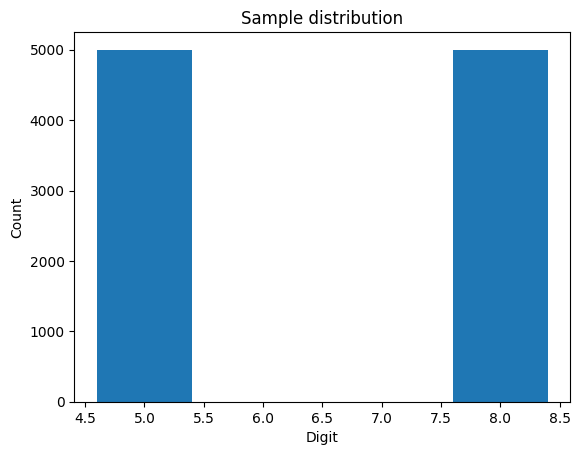

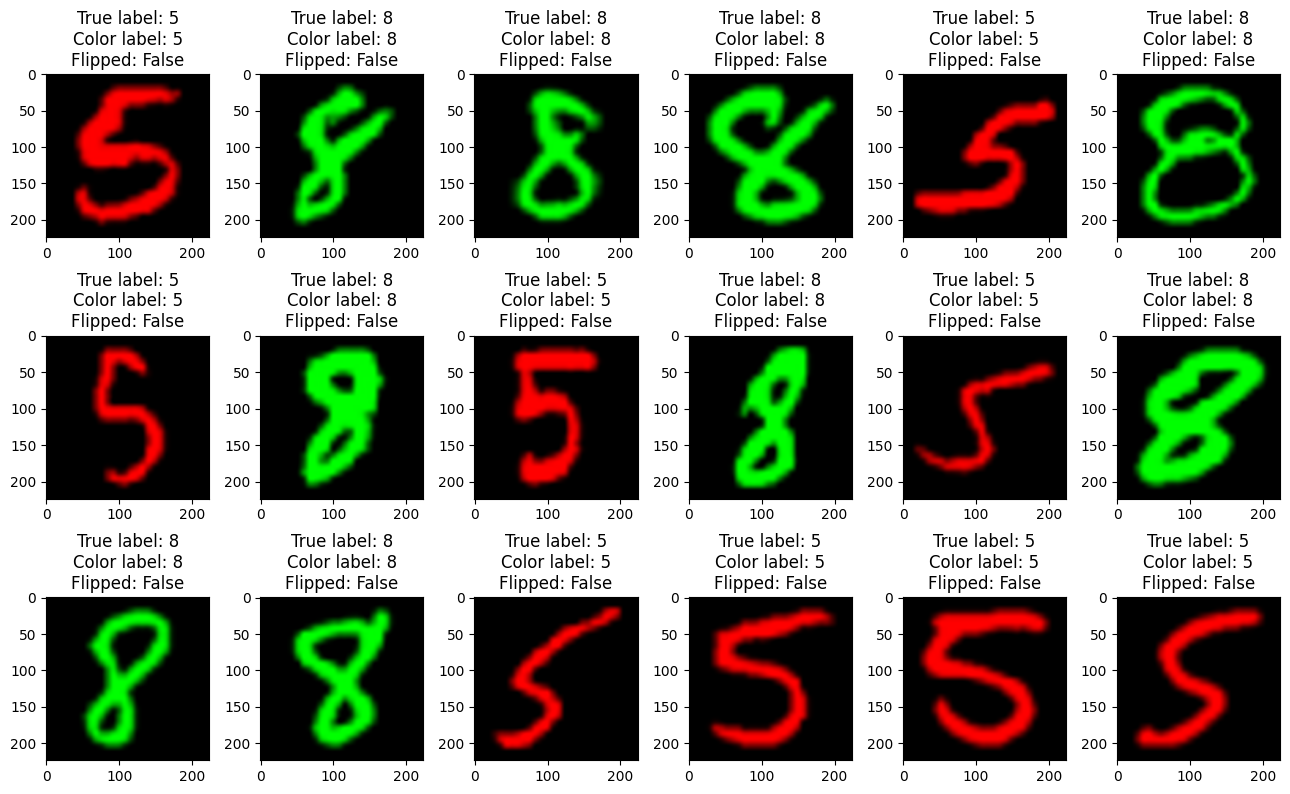

In [12]:
from torchvision import transforms

# initialize dataset
train_set = DatasetMNIST(root=DATA_DIR,
                            env='train',
                            color=True,
                            opt_postfix="2classes",
                            filter=[5,8],
                            first_color_max_nr=5,
                            preprocess=clip_preprocess,
                            test_fool_random=DATASET_TEST_FOOL_RANDOM_COLORS,
                            transform= transforms.Compose([transforms.ToTensor()]))

# create dataloaders
train_loader = torch.utils.data.DataLoader(dataset=train_set,
                                            batch_size=DATASET_BATCH_SIZE,
                                            shuffle=DATASET_SHUFFLE)

print(f"Number of training samples: {len(train_loader.dataset.data_label_tuples)}")
digit_distribution(train_set)
plot_digits(train_set, clip_preprocess)

In [13]:
# sanity check: Use batchsize, such that the number of samples in the dataset is divisible by the batchsize. This avoids complicated handling for the last batch.
if (len(train_loader.dataset.data_label_tuples) % DATASET_BATCH_SIZE != 0):
    raise Exception(f"Number of samples in dataset (={len(train_loader.dataset.data_label_tuples)}) is not divisible by the batch size (={DATASET_BATCH_SIZE})! Correct it to make life easier!")

# compute statistics

In [14]:
from torchvision import transforms

# model1 = standalone
# model2 = clip
def get_mean_std(model1, model1_layers, model2, model2_layers, dataloader, device):
        
    model1_stats_list = []
    model2_stats_list = []
    
    # do not keep track of gradients
    with torch.no_grad():
        
        # batch processing
        for iteration, data in enumerate(dataloader):
            
            # copy data to GPU
            inputs, _, _, _ = data
            inputs = inputs.to(device)
            
            print(f"Batch {iteration} is being processed...")
            
            ###############################################################################
            # Compute activations and statistics for model 1
            ###############################################################################
            # inference first model
            _ = model1(inputs)

            # store activations from current batch
            model1_activations = {}
            for layer in model1_layers:
                model1_activations[layer] = []    
                model1_activation = model1.retained_layer(layer, clear = True)
                model1_activations[layer].append(model1_activation)
            
            # compute statistics (mean and standard deviation)
            batch_model1_stats_list = []
            for layer in model1_layers:
                model1_activations[layer] = torch.cat(model1_activations[layer], 0) # images x channels x feature-map height x feature map width
                model1_activations[layer] = torch.permute(model1_activations[layer], (1,0,2,3)).contiguous() # channels x images x feature-map height x feature map width
                model1_activations[layer] = model1_activations[layer].view(model1_activations[layer].shape[0], -1) 
                batch_model1_stats_list.append([torch.mean(model1_activations[layer],dim=-1,
                                                           dtype=torch.float64).unsqueeze(0).unsqueeze(2).unsqueeze(3).to(device),
                                                torch.std(model1_activations[layer], dim=-1).unsqueeze(0).unsqueeze(2).unsqueeze(3).to(device)])

            # cleanup
            del model1_activations
            model1_stats_list.append(batch_model1_stats_list)

            ###############################################################################
            # Compute activations and statistics for model 2
            ###############################################################################
            # preprocess images
            transform = transforms.ToPILImage()
            images_new = []
            for img in inputs:
                images_new.append(clip_preprocess(transform(img)))

            # building image features
            images = torch.tensor(np.stack(images_new)).cuda()
            
            # inference second model
            _ = model2.model.encode_image(images)

            # store activations from current batch
            model2_activations = {}
            for layer in model2_layers:
                model2_activations[layer] = []    
                model2_activation = model2.retained_layer(layer, clear = True)
                model2_activations[layer].append(model2_activation)

            # compute statistics (mean and standard deviation)
            batch_model2_stats_list = []
            model2_stats_list.append(batch_model2_stats_list)
            for layer in model2_layers:
                model2_activations[layer] = torch.cat(model2_activations[layer], 0)
                model2_activations[layer] = torch.permute(model2_activations[layer], (1,0,2,3)).contiguous()
                model2_activations[layer] = model2_activations[layer].view(model2_activations[layer].shape[0], -1)
                batch_model2_stats_list.append([torch.mean(model2_activations[layer], dim=-1,
                                                           dtype=torch.float64).unsqueeze(0).unsqueeze(2).unsqueeze(3).to(device),
                                                torch.std(model2_activations[layer], dim=-1).unsqueeze(0).unsqueeze(2).unsqueeze(3).to(device)])

            # cleanup
            del model2_activations
            torch.cuda.empty_cache()
                    
        ###############################################################################
        # All batches processed, create final statistics
        ###############################################################################
        # compute mean of means and mean of standard deviations for model 1
        final_model1_stats_list = []

        for iii in range(len(batch_model1_stats_list)):
            means = torch.zeros_like(batch_model1_stats_list[iii][0])
            stds = torch.zeros_like(batch_model1_stats_list[iii][1])
            for jjj in range((iteration+1)):
                means+=model1_stats_list[jjj][iii][0]
                stds+=model1_stats_list[jjj][iii][1]**2

            final_model1_stats_list.append([means/(iteration+1), torch.sqrt(stds/(iteration+1))])
        
        # compute mean of means and mean of standard deviations for model 2
        final_model2_stats_list = []

        for iii in range(len(batch_model2_stats_list)):
            means = torch.zeros_like(batch_model2_stats_list[iii][0])
            stds = torch.zeros_like(batch_model2_stats_list[iii][1])
            for jjj in range((iteration+1)):
                means+=model2_stats_list[jjj][iii][0]
                stds+=model2_stats_list[jjj][iii][1]**2

            final_model2_stats_list.append([means/(iteration+1), torch.sqrt(stds/(iteration+1))])

    return final_model1_stats_list, final_model2_stats_list

In [15]:
def save_array(array, filename):
    open_file = open(filename, "wb")
    pickle.dump(array, open_file)
    open_file.close()

In [16]:
from utils import matching, nethook, stats

def compute_statistics(model1, model1_layers, model2, model2_layers, dataloader, device):
    model1.eval()
    model2.eval()
    
    # hook layers for model 1
    model1 = nethook.InstrumentedModel(model1)
    model1.retain_layers(model1_layers)
    
    # hook layers for model 2
    model2 = nethook.InstrumentedModel(model2)
    model2.retain_layers(model2_layers)
    
    # compute dataset statistics
    model1_statistics_table, model2_statistics_table = get_mean_std(model1, model1_layers, model2, model2_layers, dataloader, device)
    save_array(model1_statistics_table, "/mnt/data/patrick.koller/masterthesis/data/results/model1_statistics.pkl")
    save_array(model2_statistics_table, "/mnt/data/patrick.koller/masterthesis/data/results/model2_statistics.pkl")

In [17]:
import time

start_time = time.time()

compute_statistics(standalone_model, standalone_layers,
                   clip_model, clip_layers,
                   dataloader=train_loader,
                   device=device)   

end_time = time.time()

print(f"Runtime: {np.round(end_time - start_time, 3)}s")

Batch 0 is being processed...
Batch 1 is being processed...
Batch 2 is being processed...
Batch 3 is being processed...
Batch 4 is being processed...
Batch 5 is being processed...
Batch 6 is being processed...
Batch 7 is being processed...
Batch 8 is being processed...
Batch 9 is being processed...
Batch 10 is being processed...
Batch 11 is being processed...
Batch 12 is being processed...
Batch 13 is being processed...
Batch 14 is being processed...
Batch 15 is being processed...
Batch 16 is being processed...
Batch 17 is being processed...
Batch 18 is being processed...
Batch 19 is being processed...
Batch 20 is being processed...
Batch 21 is being processed...
Batch 22 is being processed...
Batch 23 is being processed...
Batch 24 is being processed...
Batch 25 is being processed...
Batch 26 is being processed...
Batch 27 is being processed...
Batch 28 is being processed...
Batch 29 is being processed...
Batch 30 is being processed...
Batch 31 is being processed...
Batch 32 is being 

# analyze statistics

In [21]:
def load_stats(root, device):

    # load table
    file_name = os.path.join(root, "table.pkl")
    with open(file_name, 'rb') as f:
        table = pickle.load(f)
        table = table.to(device)#cpu()
    
    # load statistics from model 1
    with open(os.path.join(root,"model1_statistics.pkl"), 'rb') as f:
        model1_statistics = pickle.load(f)
        for iii, item1 in enumerate(model1_statistics):
            for jjj, item2 in enumerate(model1_statistics[iii]):
                model1_statistics[iii][jjj] = model1_statistics[iii][jjj].to(device)
                
    # load statistics from model 2
    with open(os.path.join(root,"model2_statistics.pkl"), 'rb') as f:
        model2_statistics = pickle.load(f)
        
        for iii, item1 in enumerate(model2_statistics):
            for jjj, item2 in enumerate(model2_statistics[iii]):
                model2_statistics[iii][jjj] = model2_statistics[iii][jjj].to(device)
        
    return table, model1_statistics, model2_statistics



def plot_layer_mean_std(model_statistics, modelname="Modelname"):
    
    print(modelname)
    
    for i in range(len(model_statistics)):
        # first index: layer index
        # second index: mean=0 or std=1
        plt.subplot(1,2,1)
        plt.hist(model_statistics[i][0].cpu().flatten())
        plt.title(f"Mean of layer {i}")
        plt.xlabel("Value")
        plt.ylabel("Frequency")

        plt.subplot(1,2,2)
        plt.hist(model_statistics[i][1].cpu().flatten())
        plt.title(f"Standard deviation of layer {i}")
        plt.xlabel("Value")
        plt.ylabel("Frequency")

        plt.tight_layout()
        plt.show()

Model 1


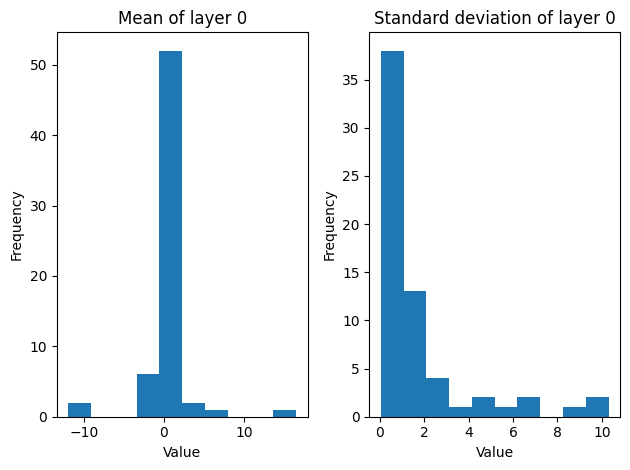

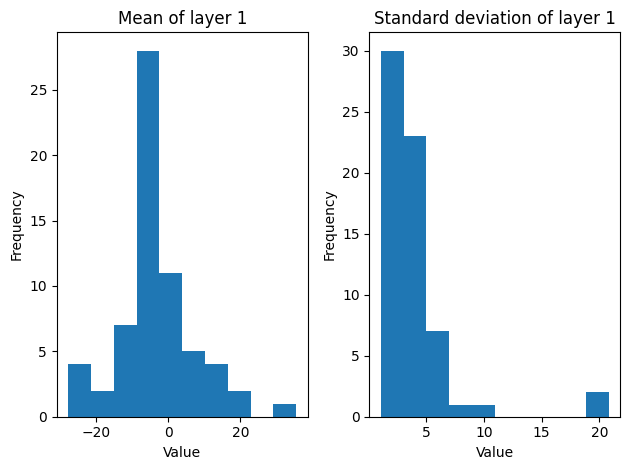

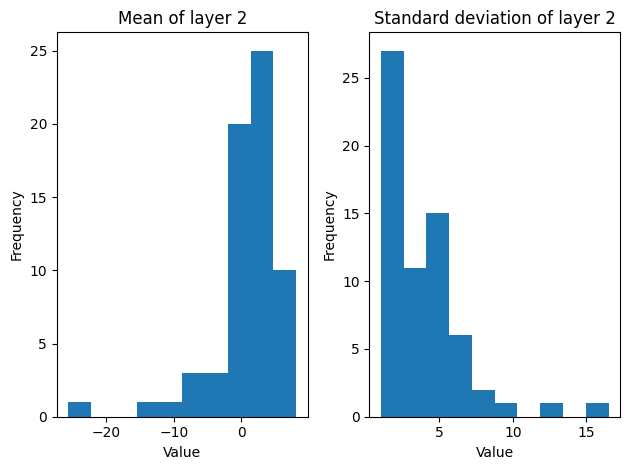

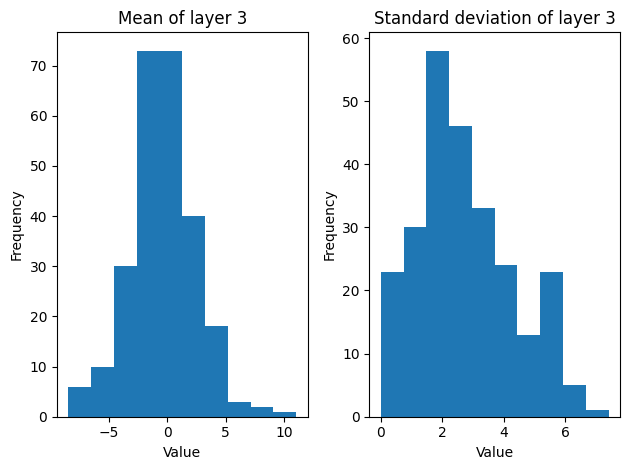

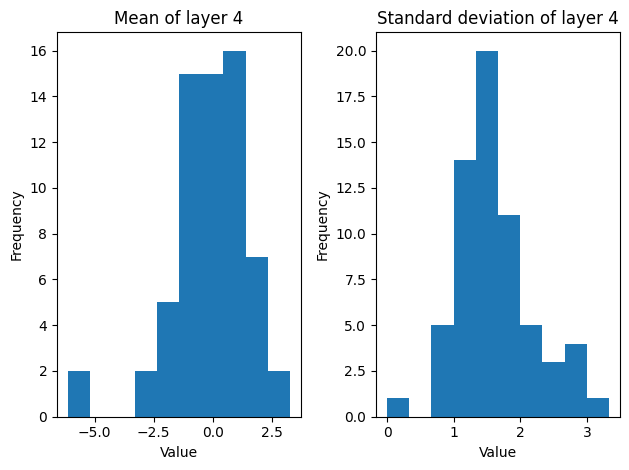

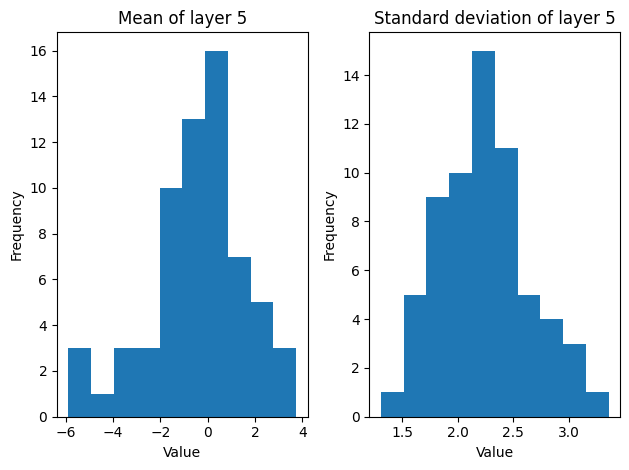

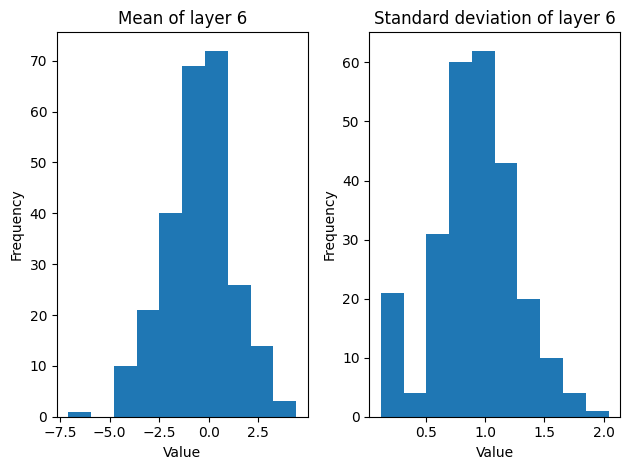

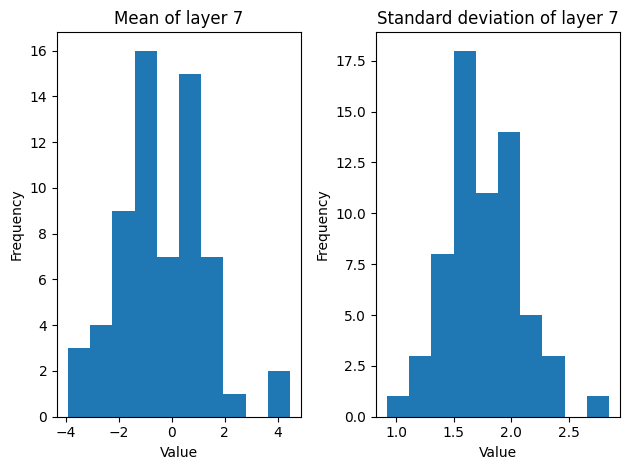

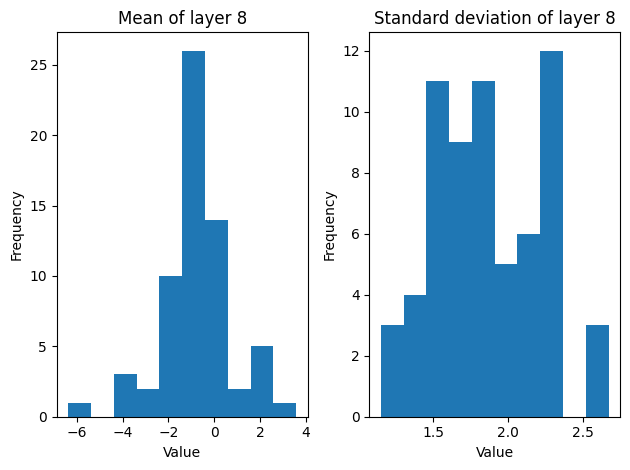

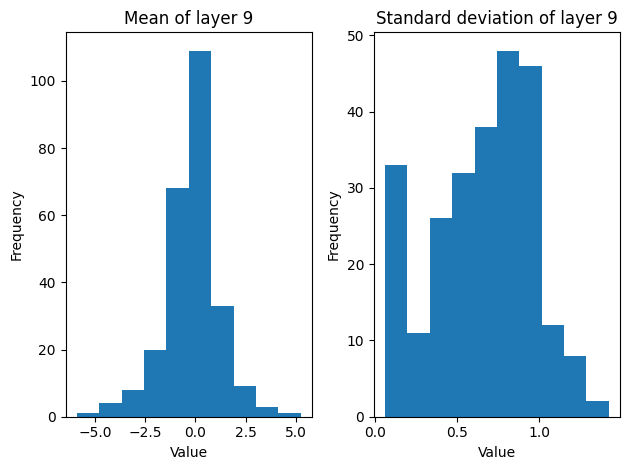

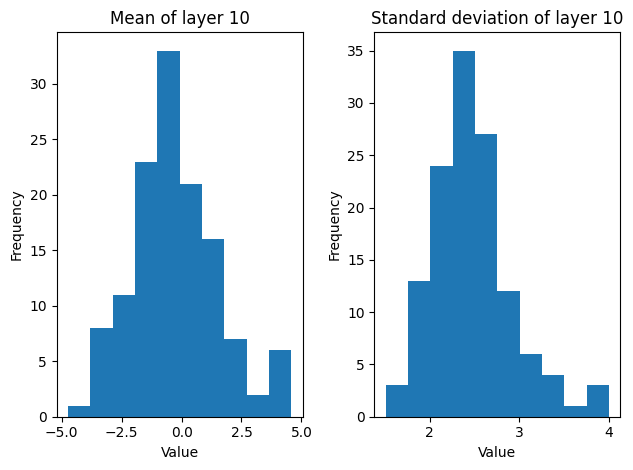

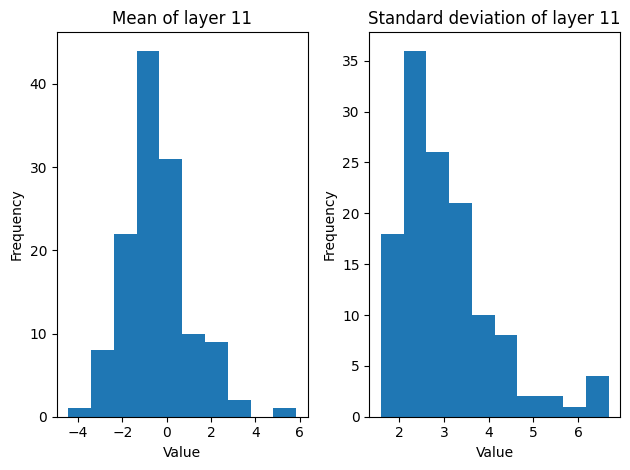

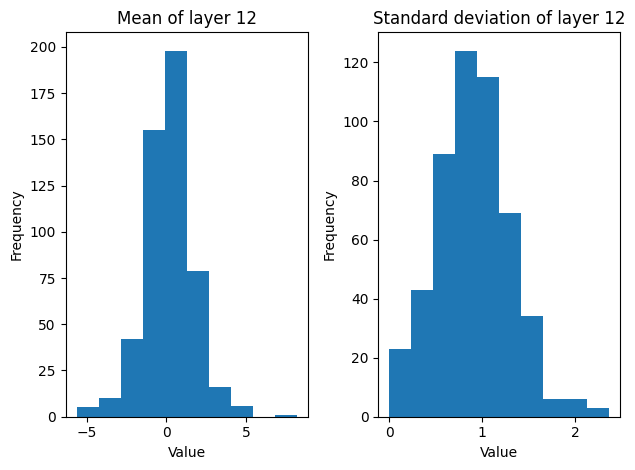

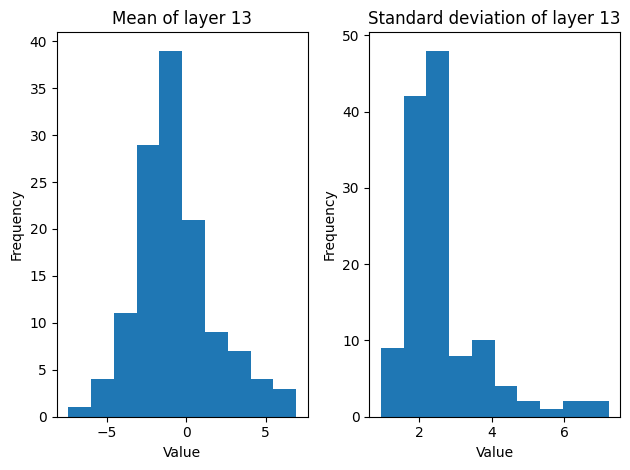

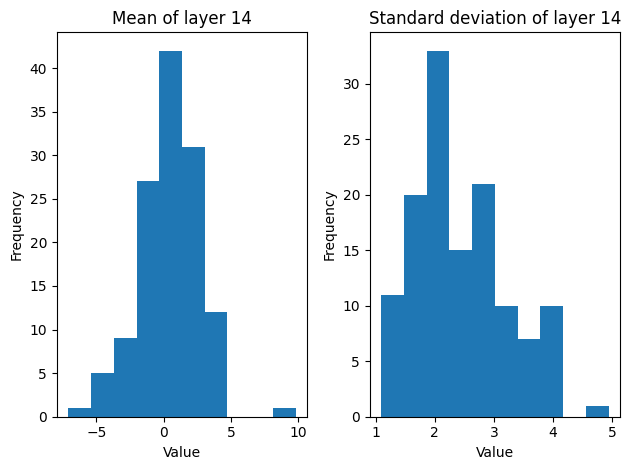

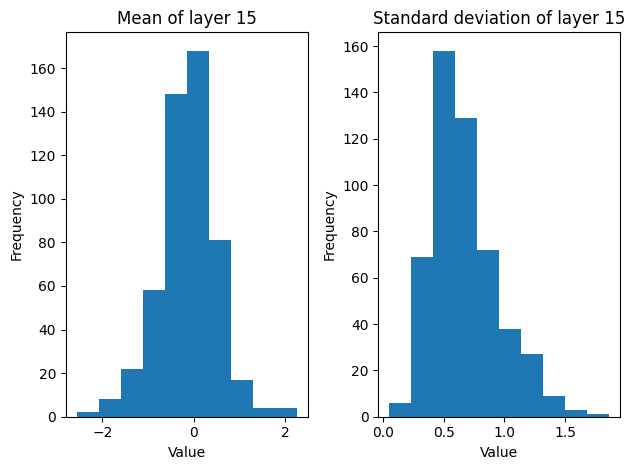

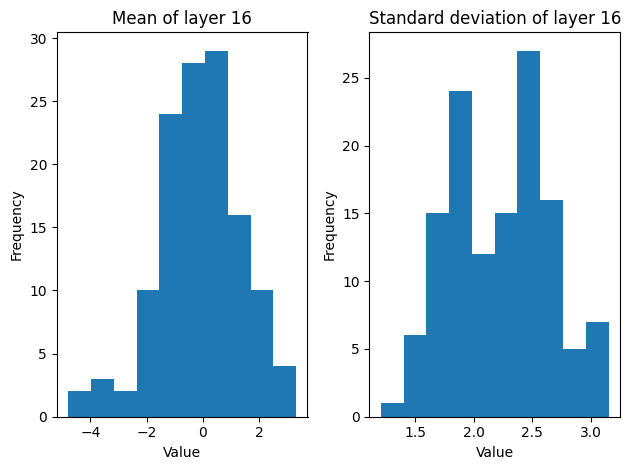

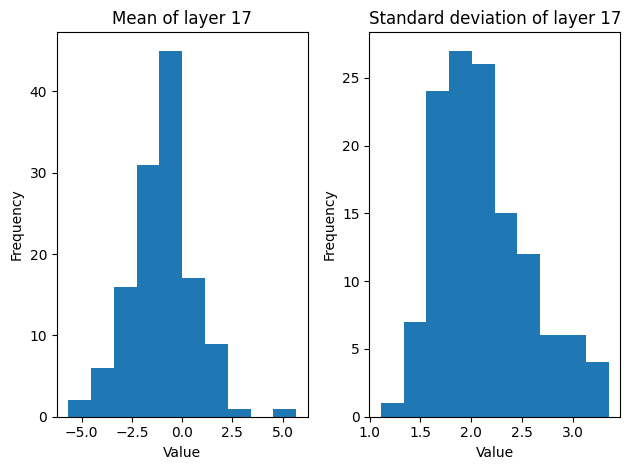

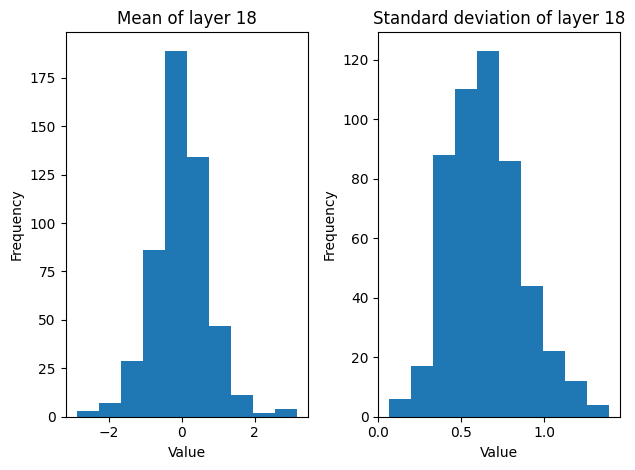

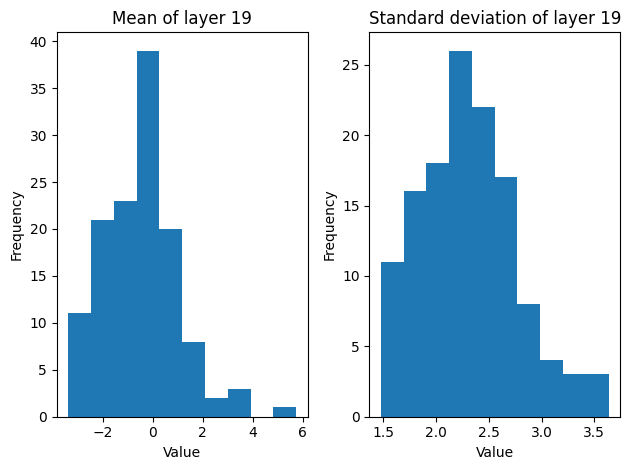

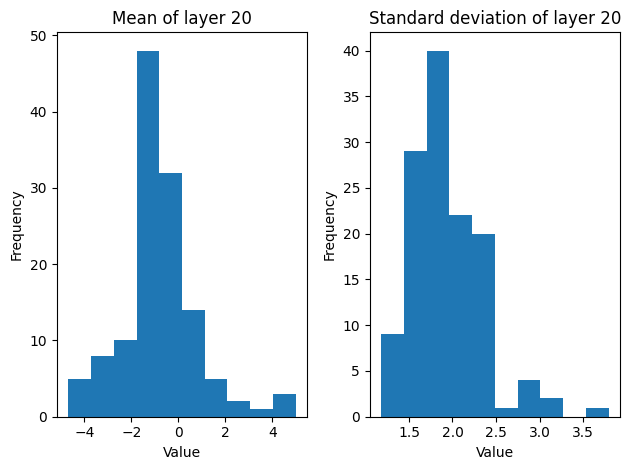

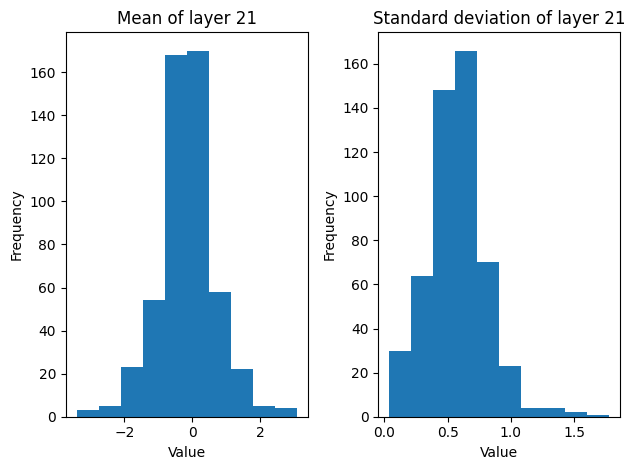

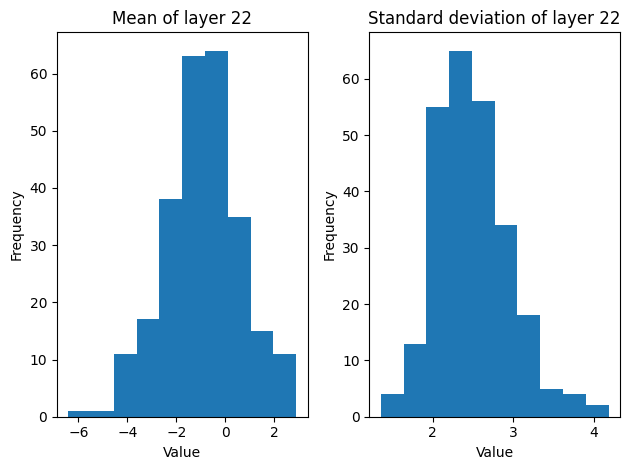

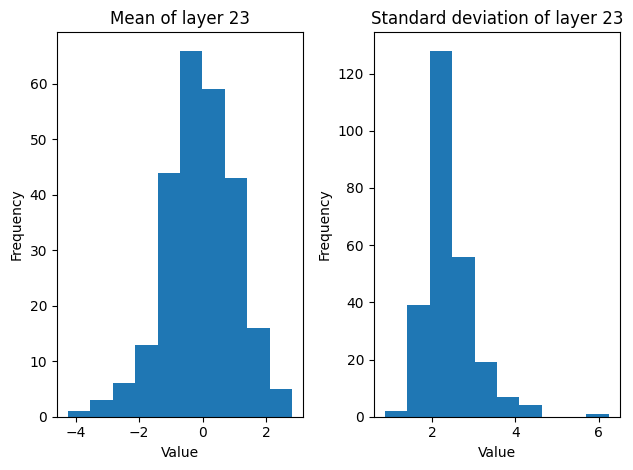

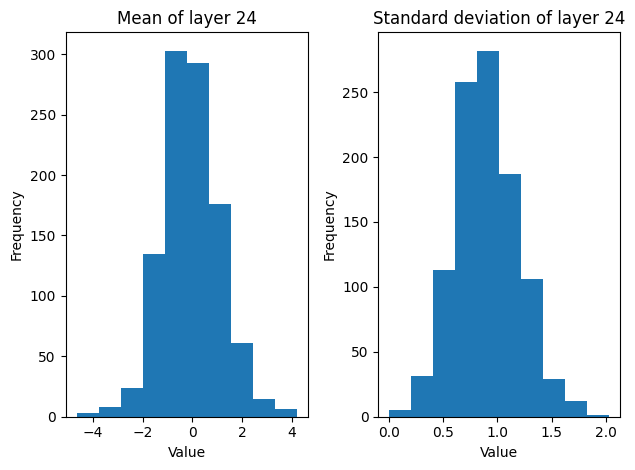

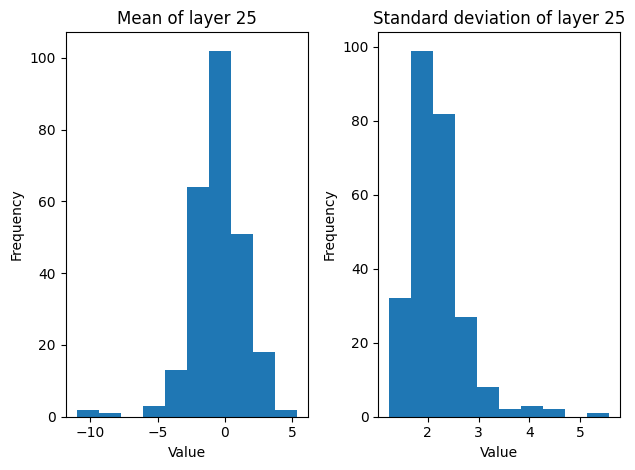

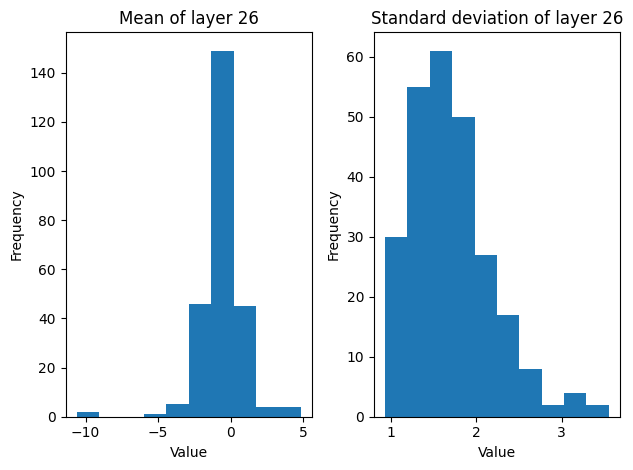

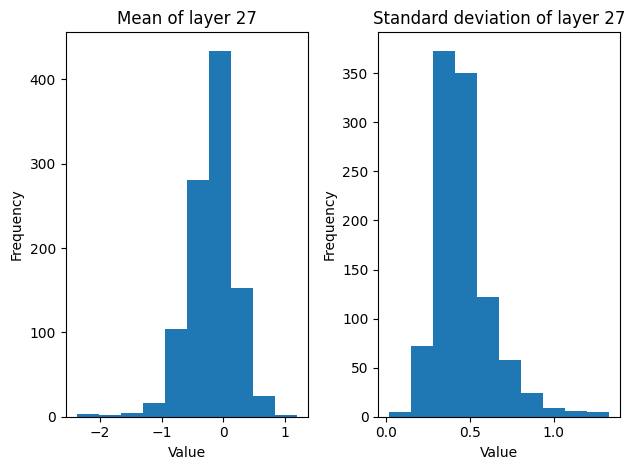

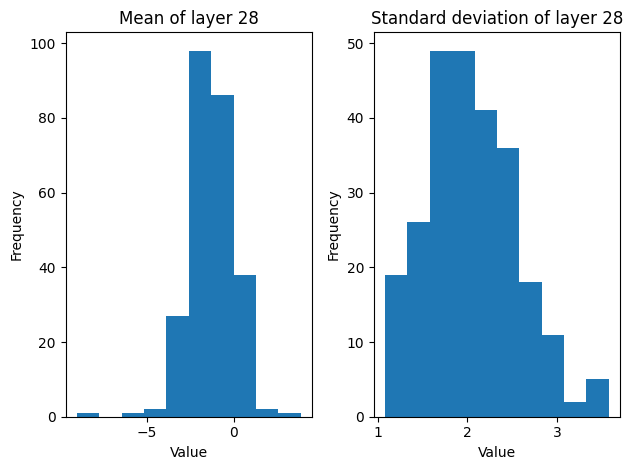

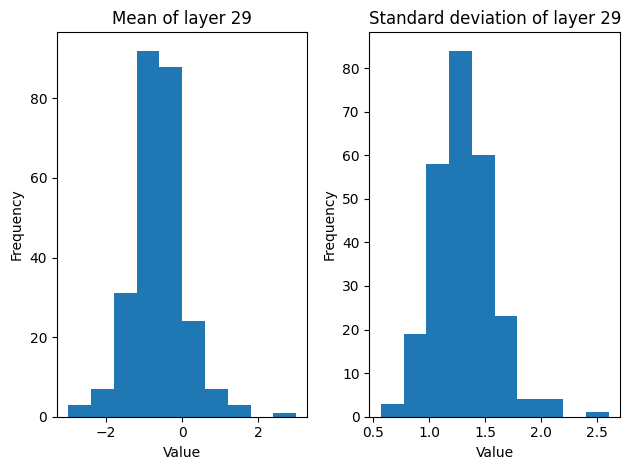

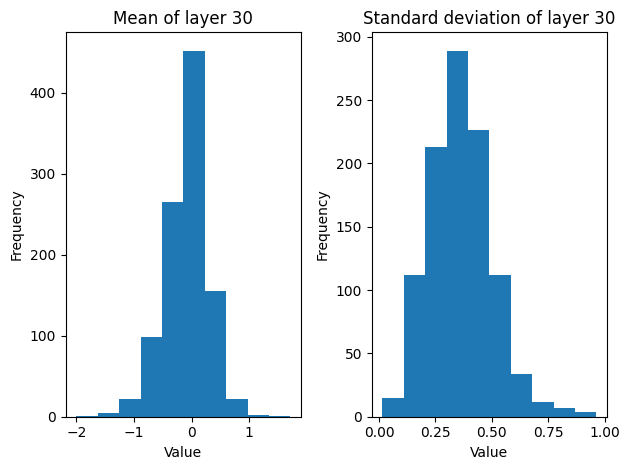

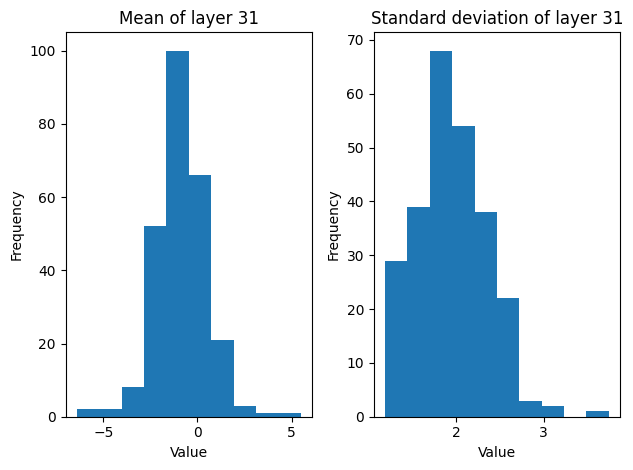

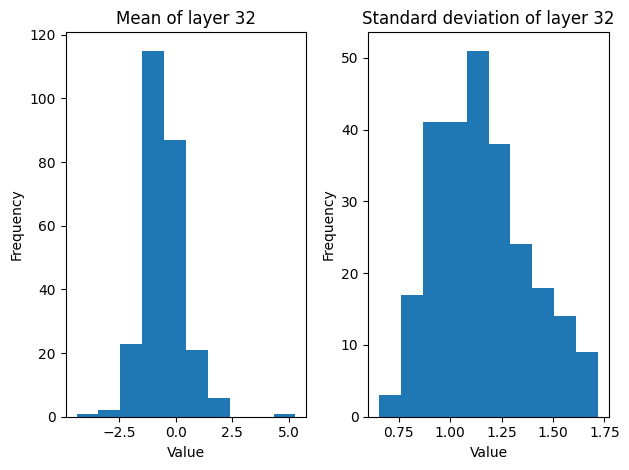

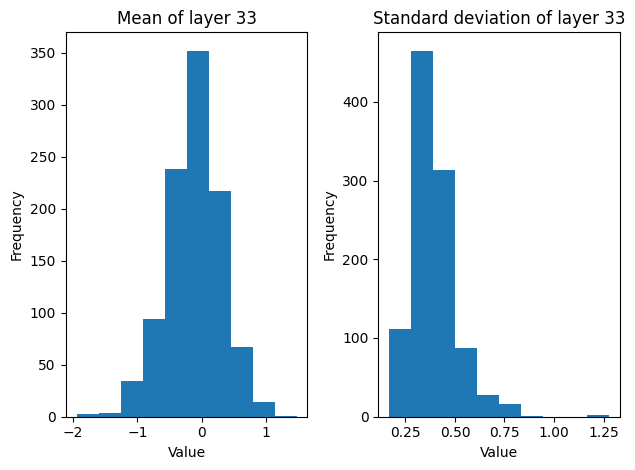

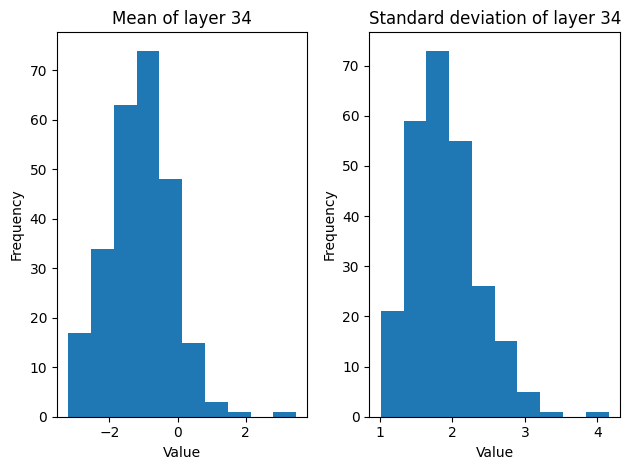

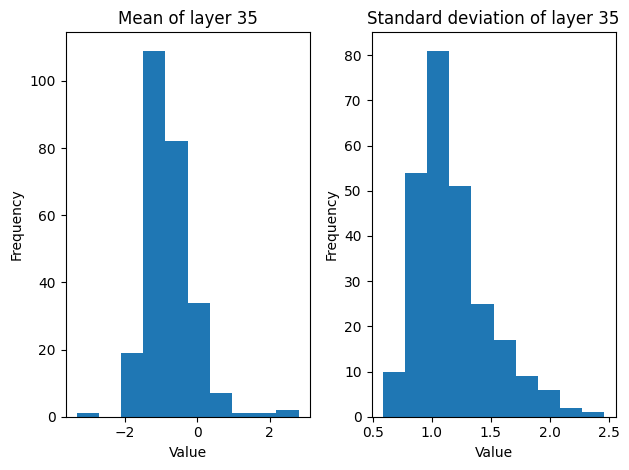

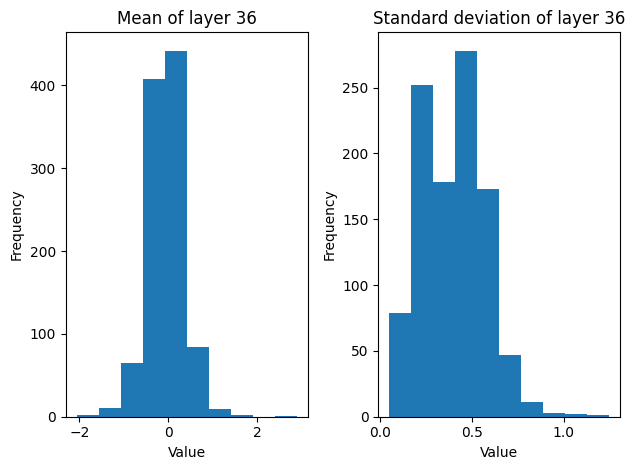

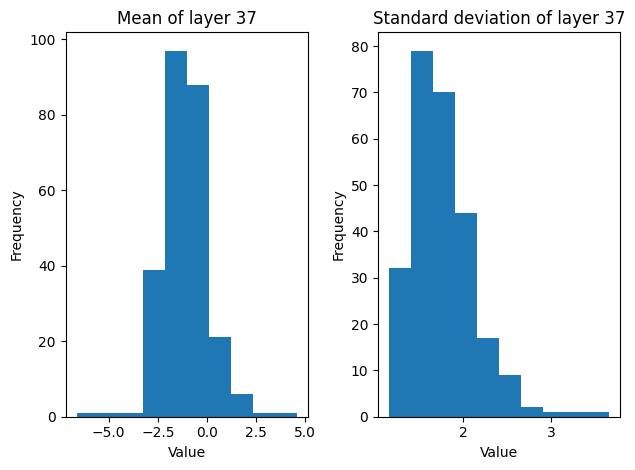

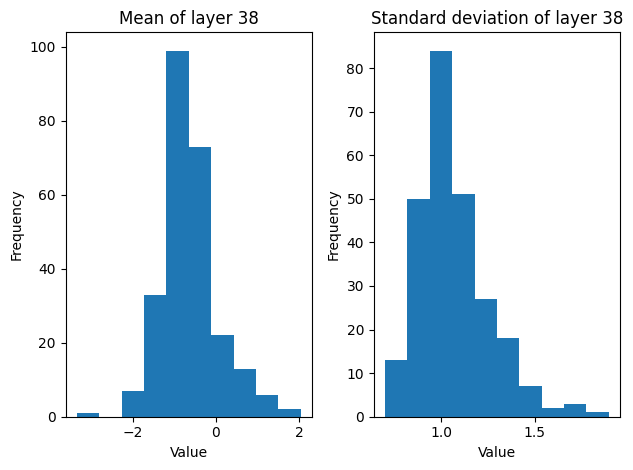

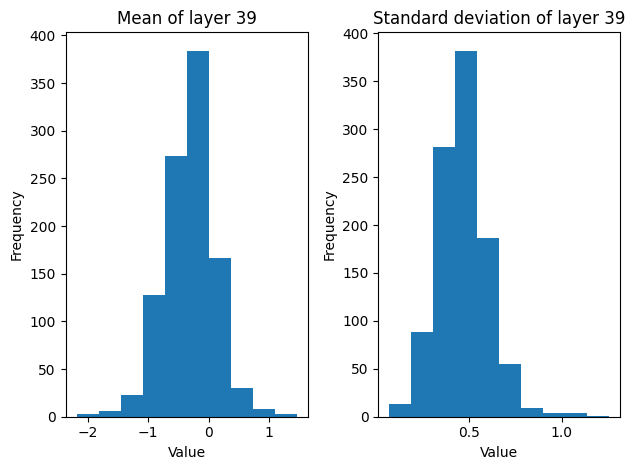

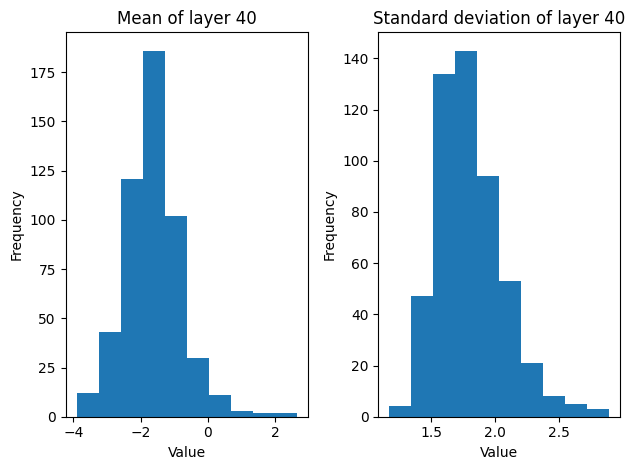

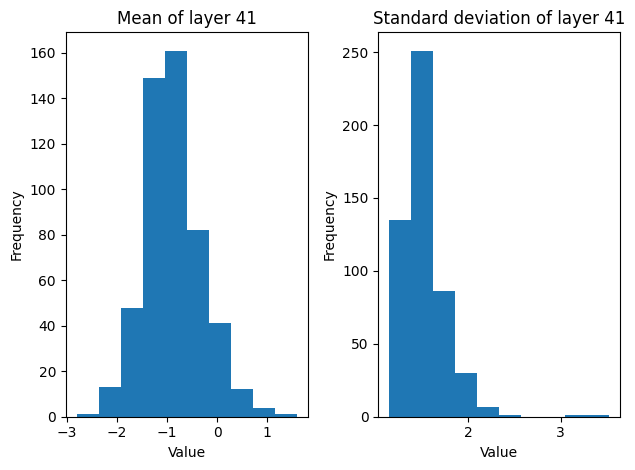

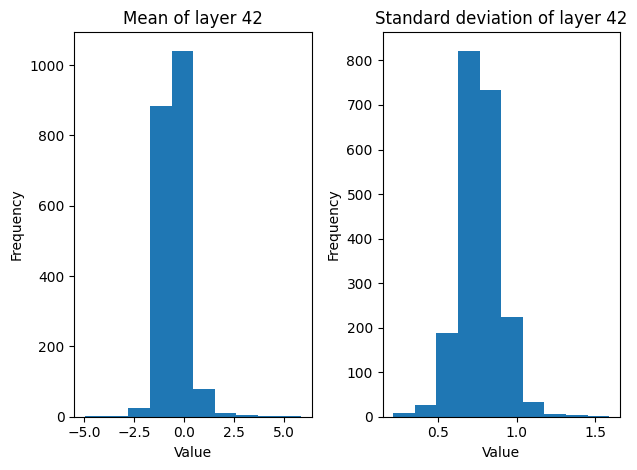

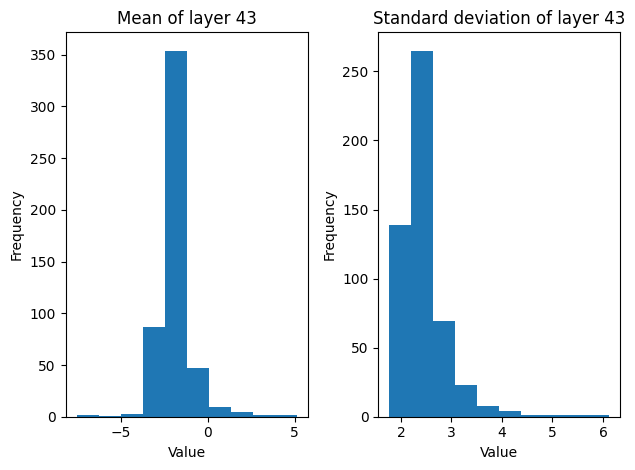

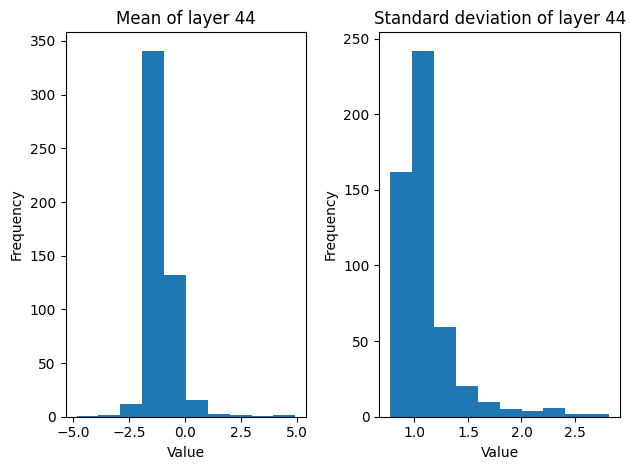

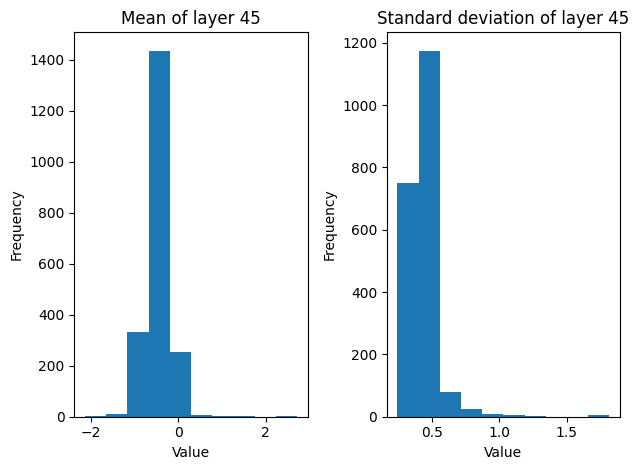

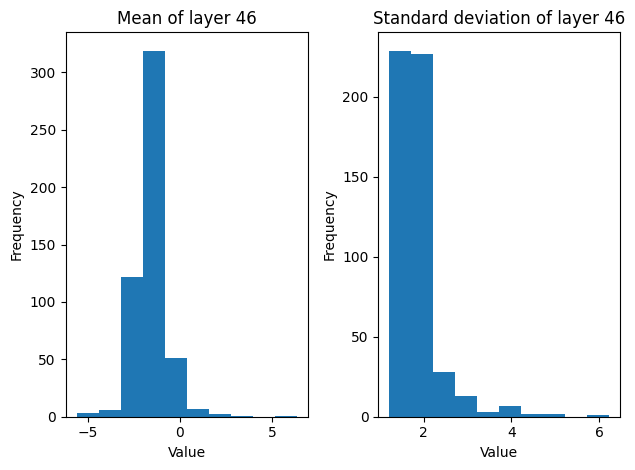

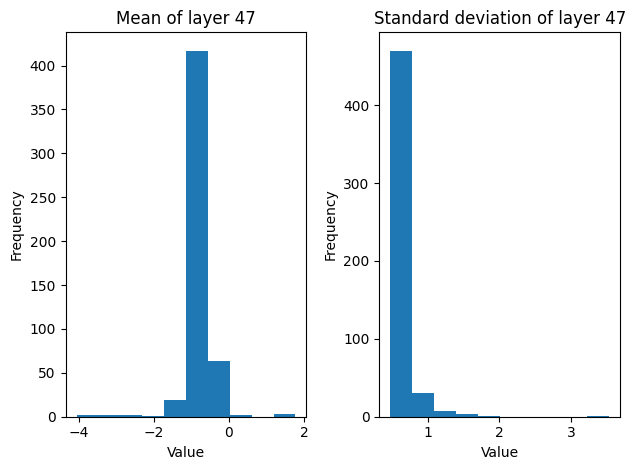

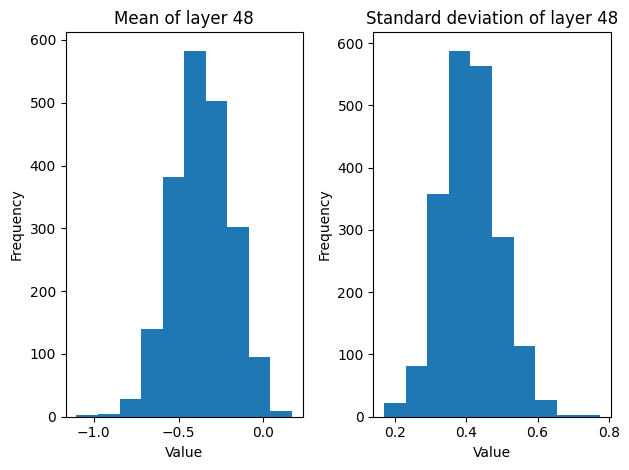

Model 2


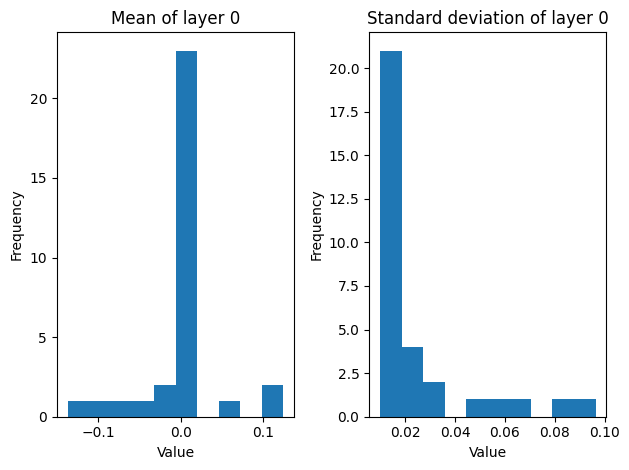

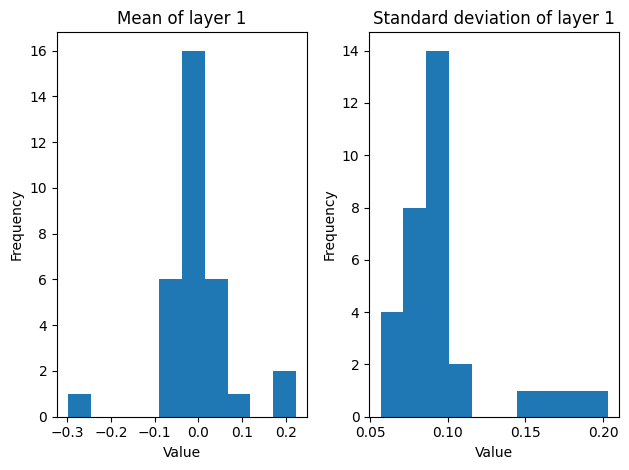

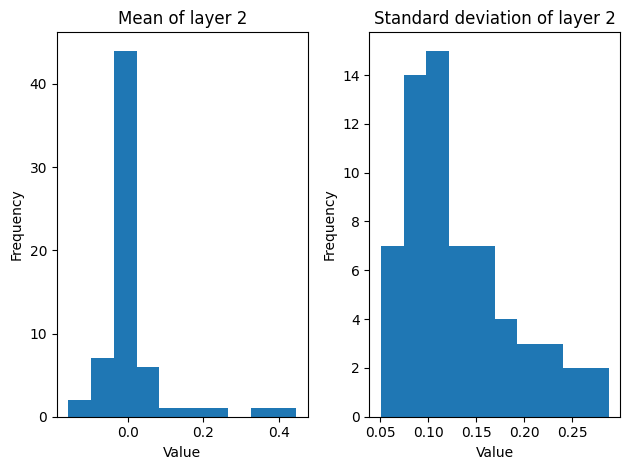

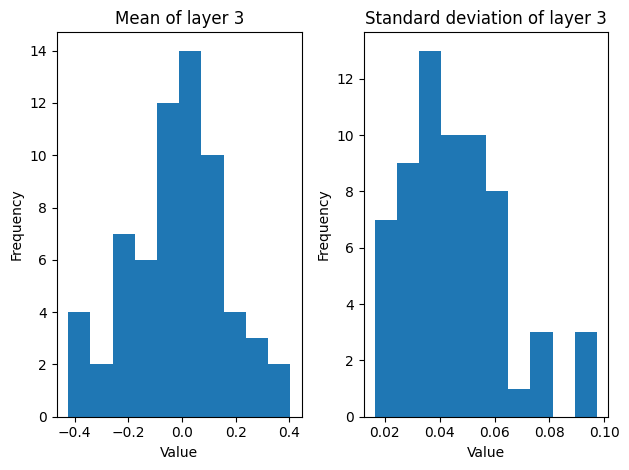

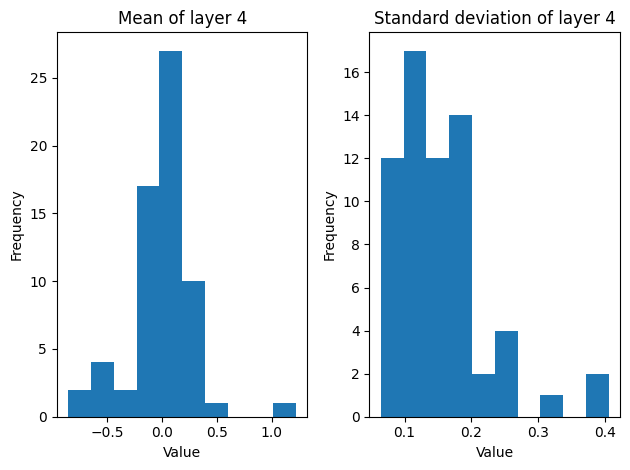

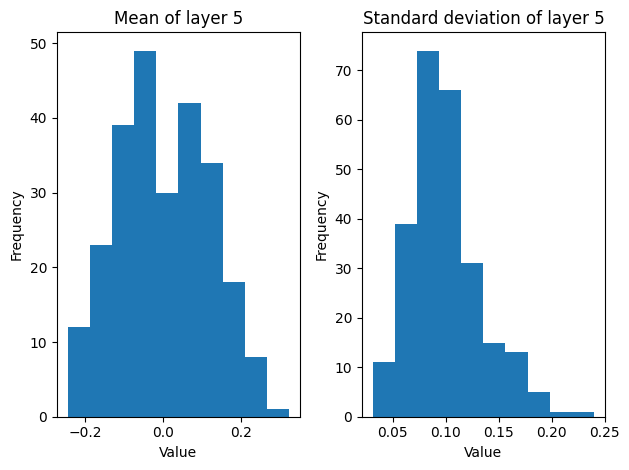

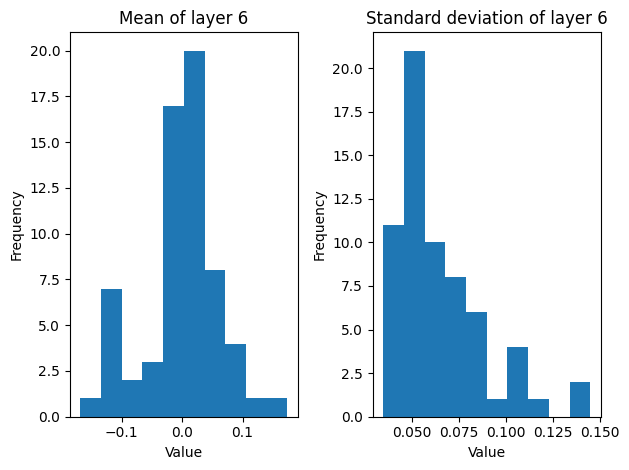

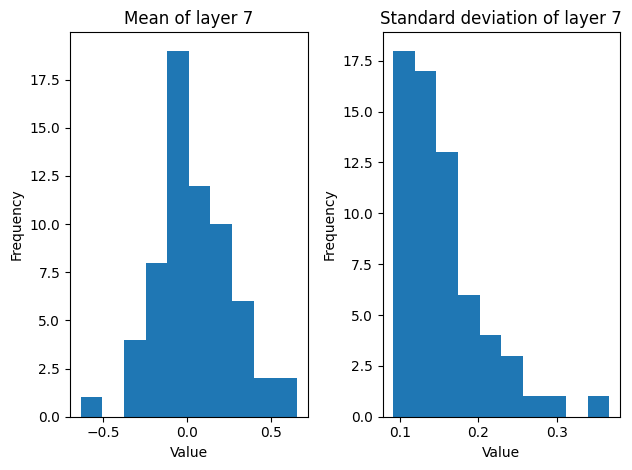

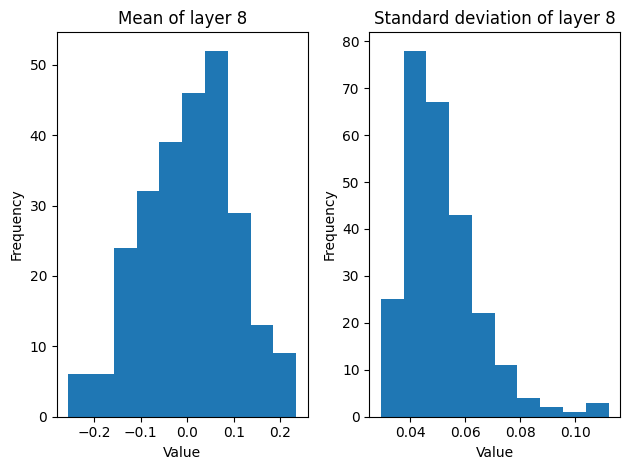

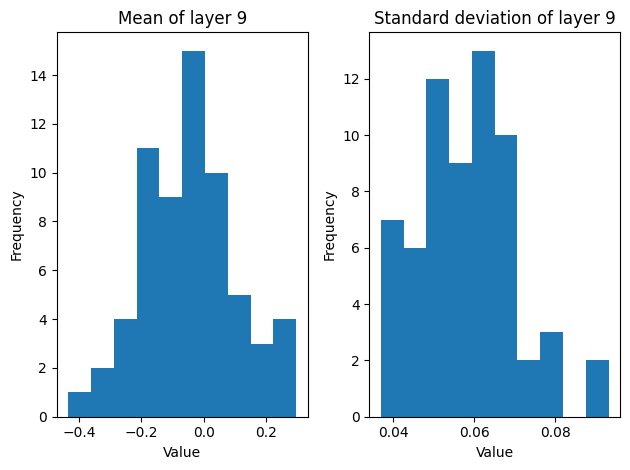

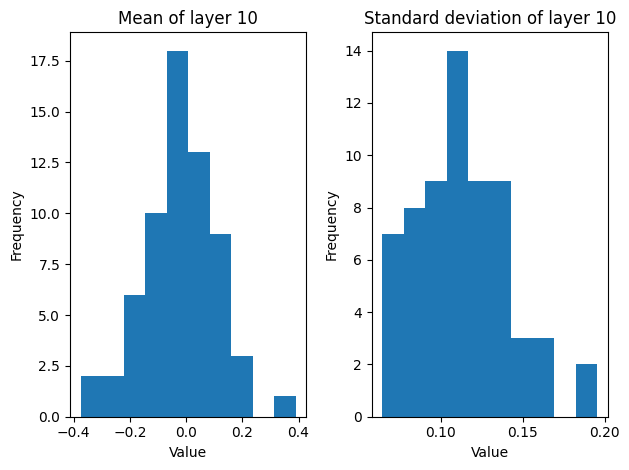

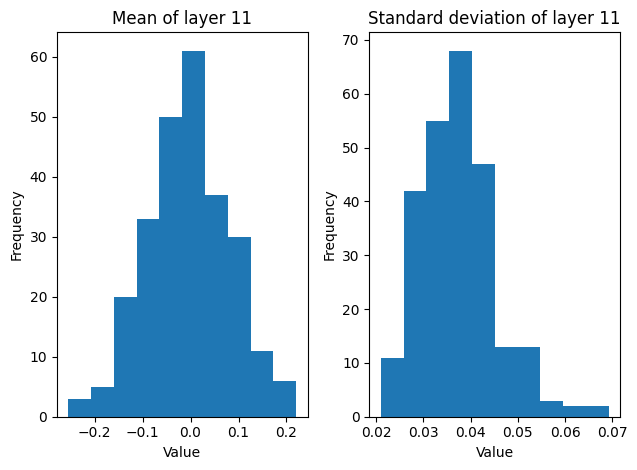

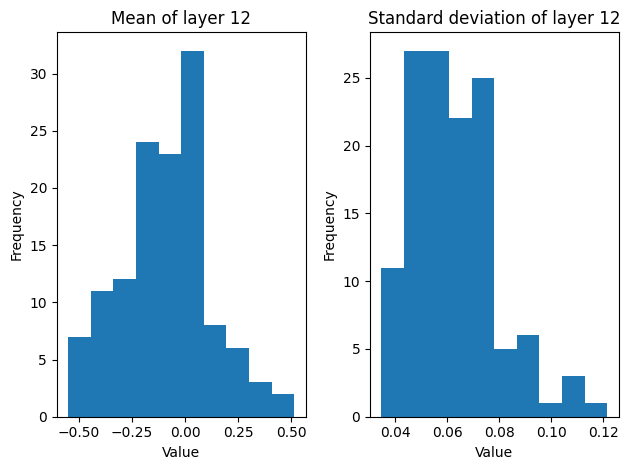

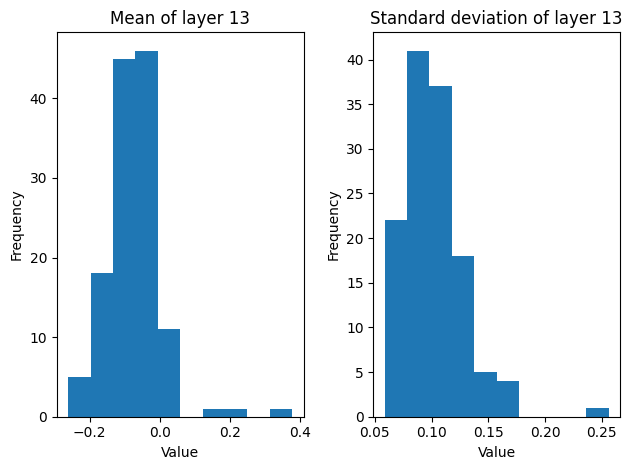

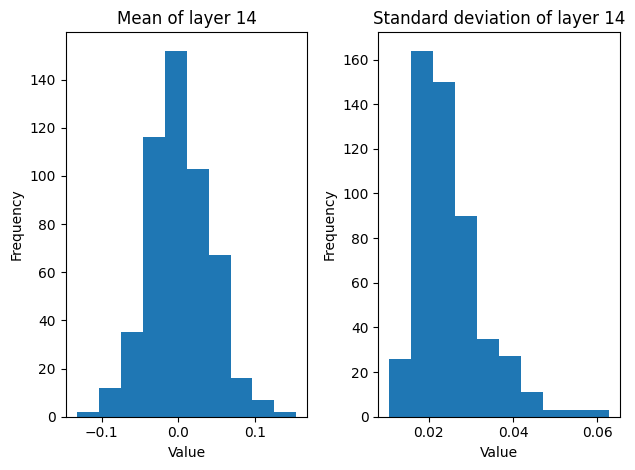

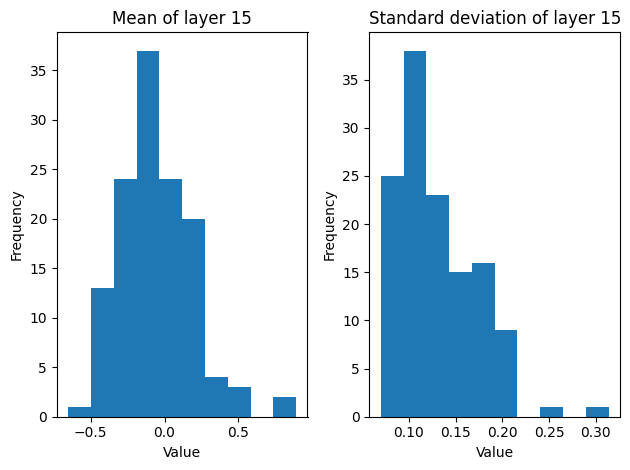

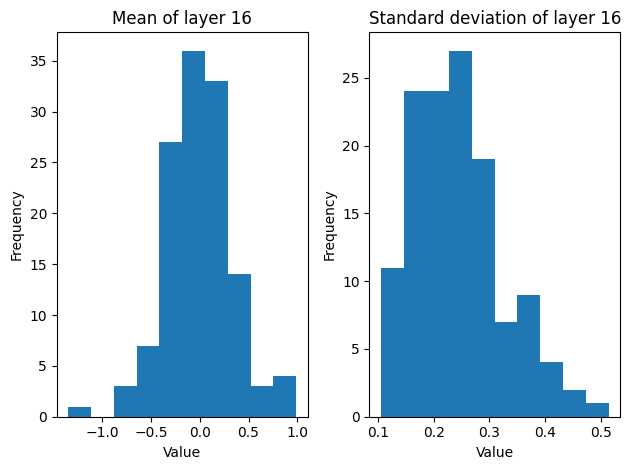

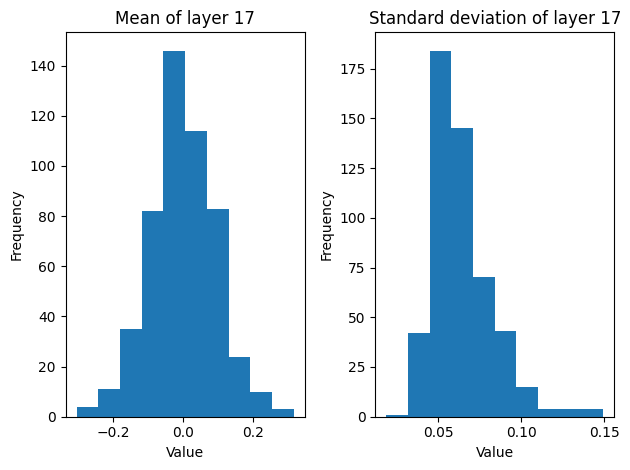

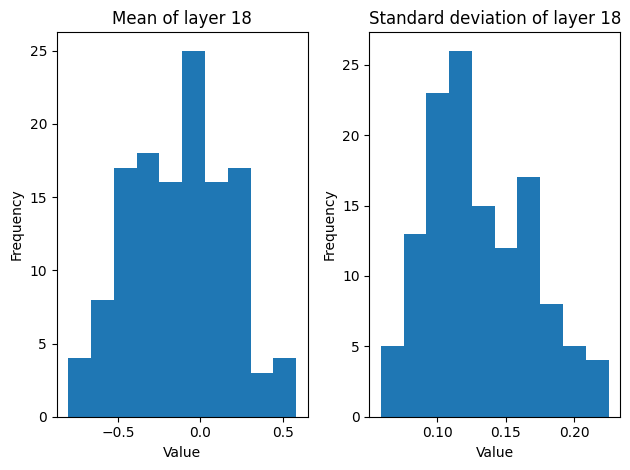

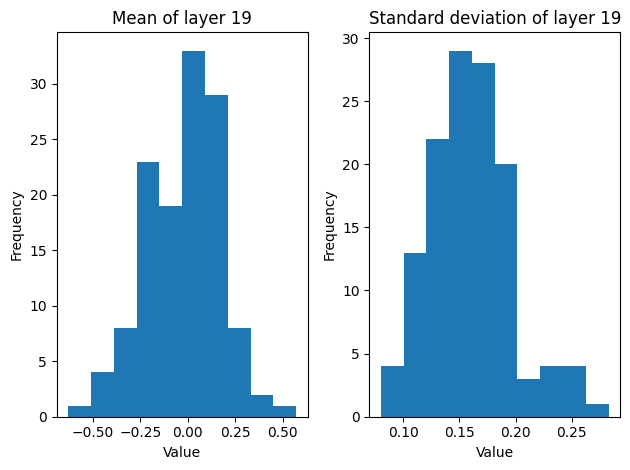

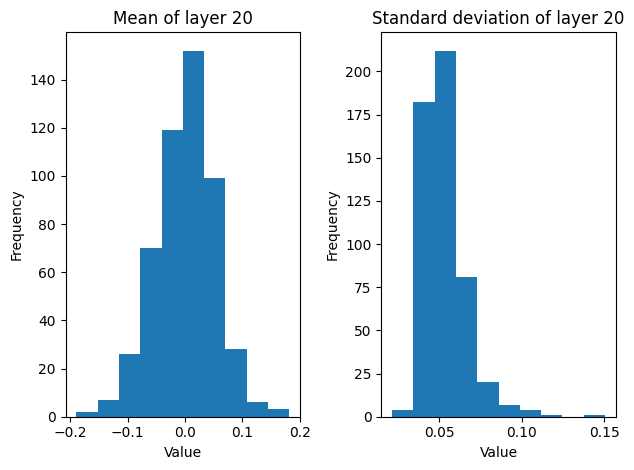

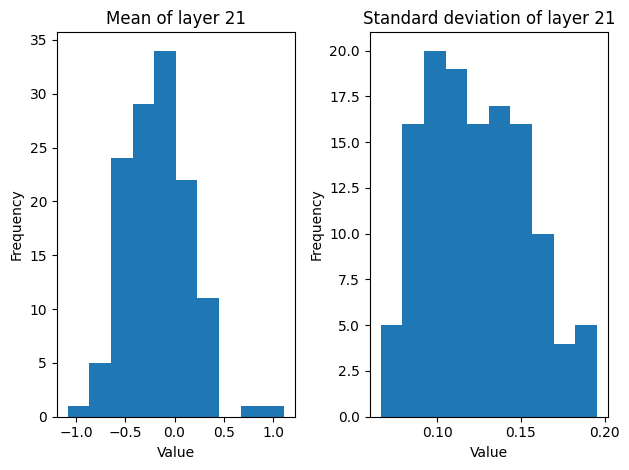

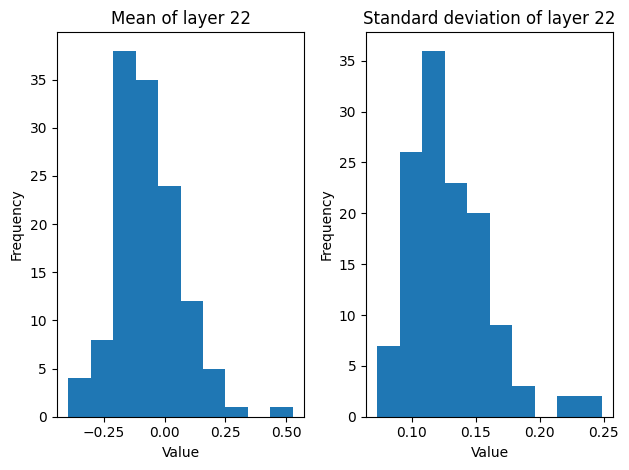

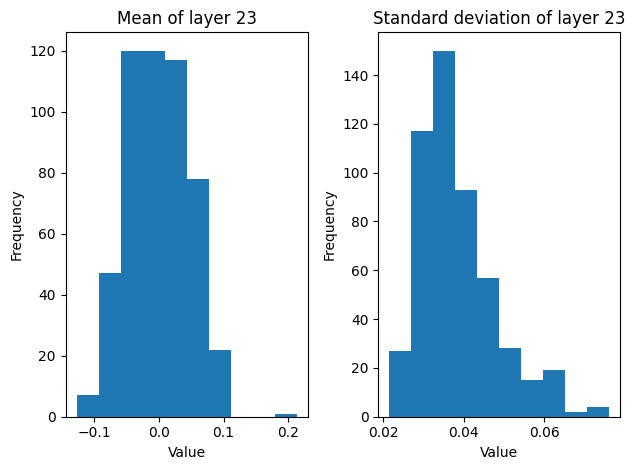

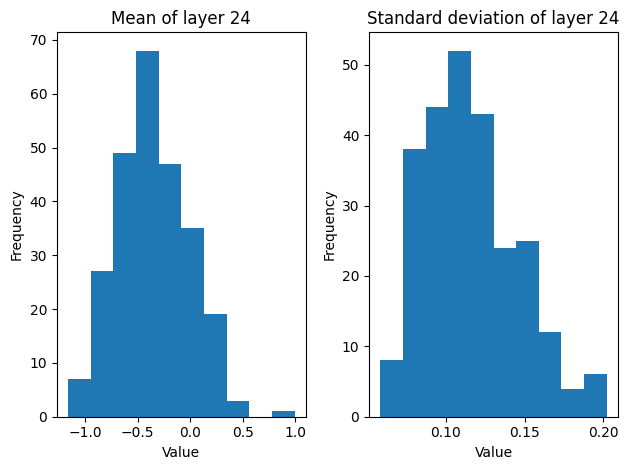

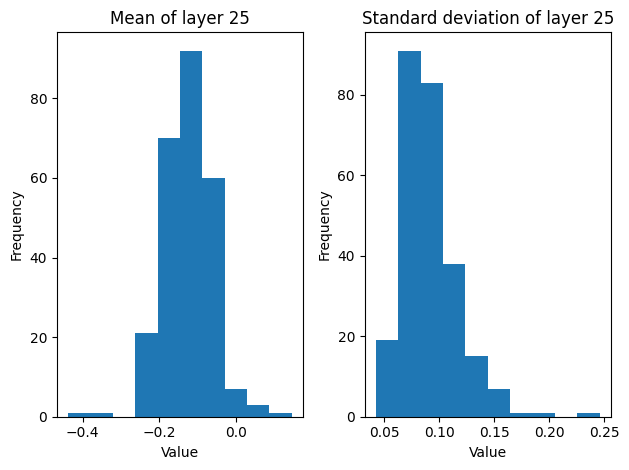

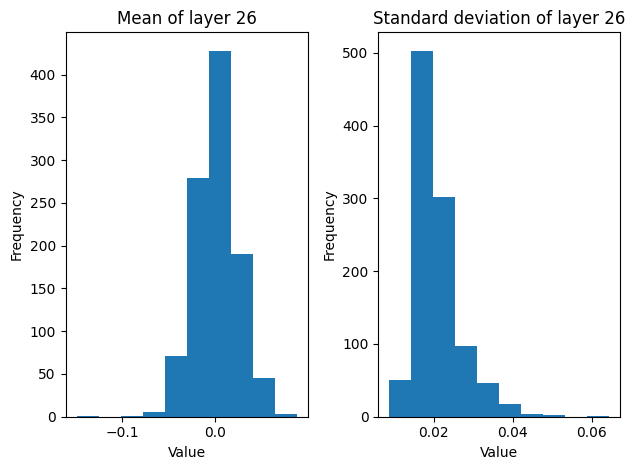

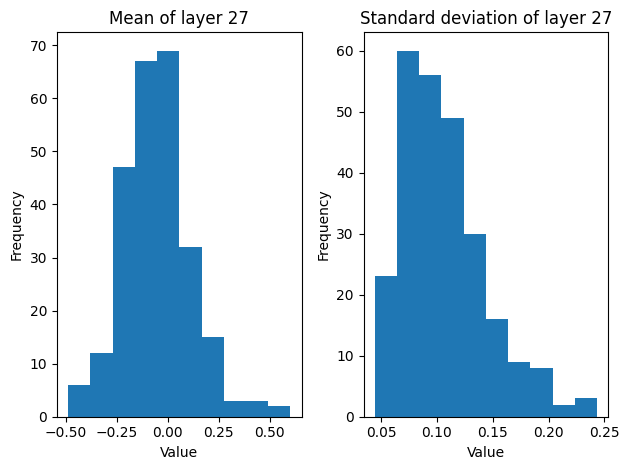

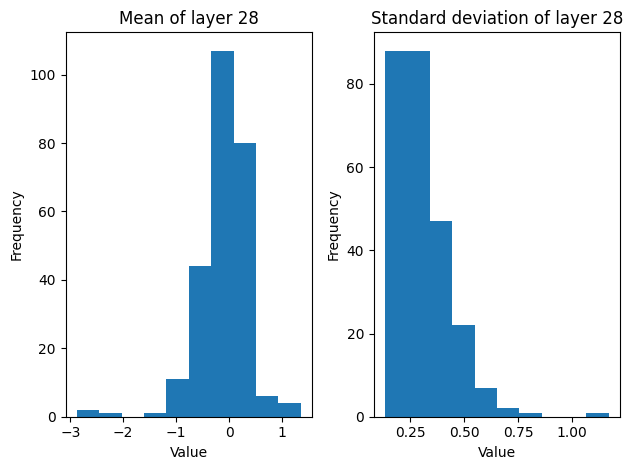

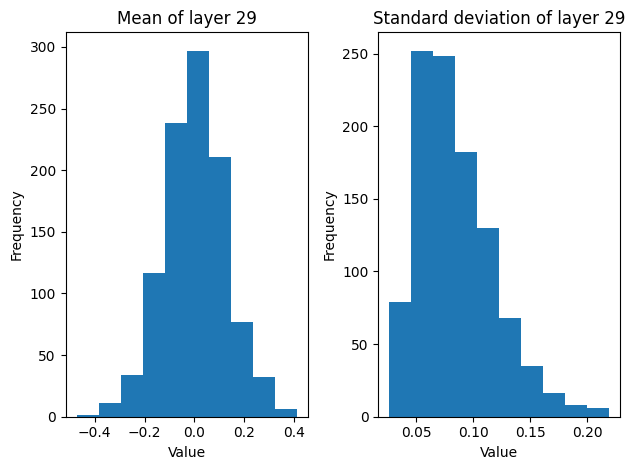

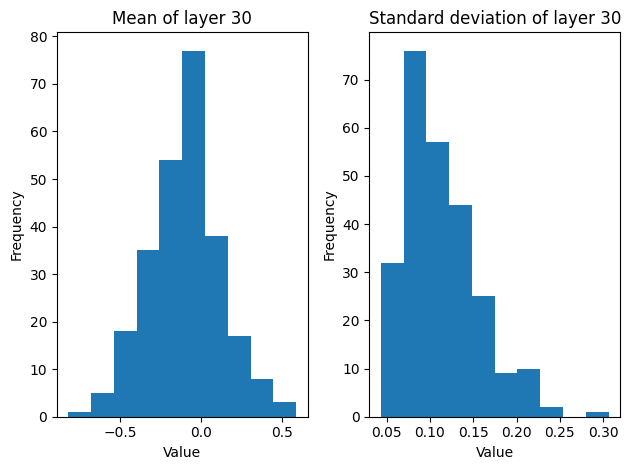

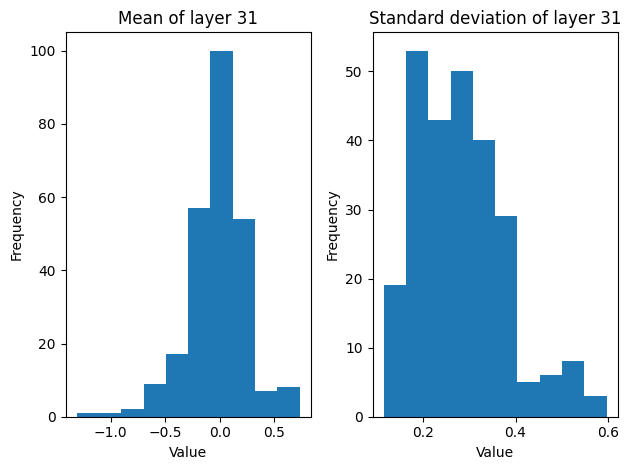

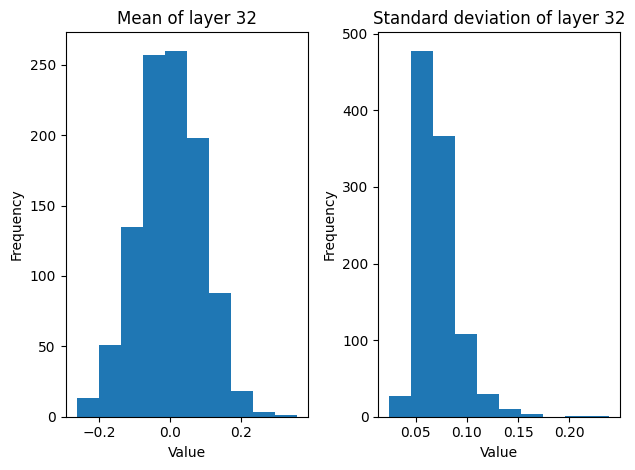

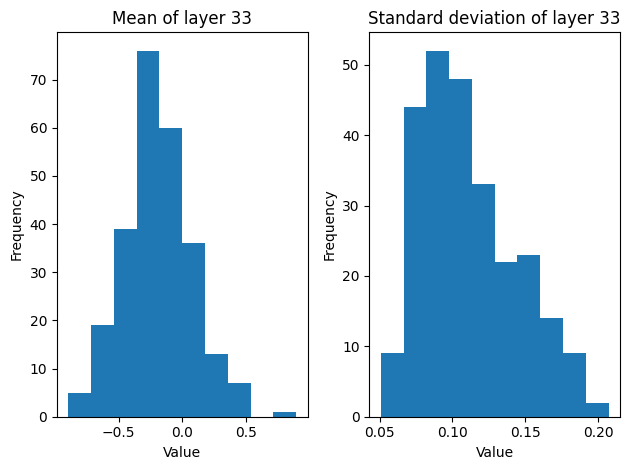

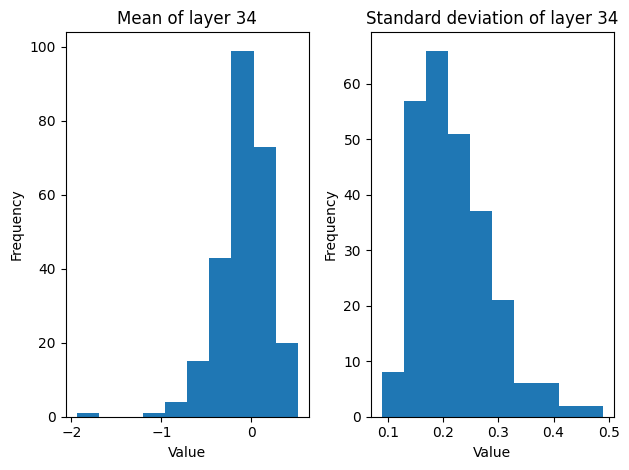

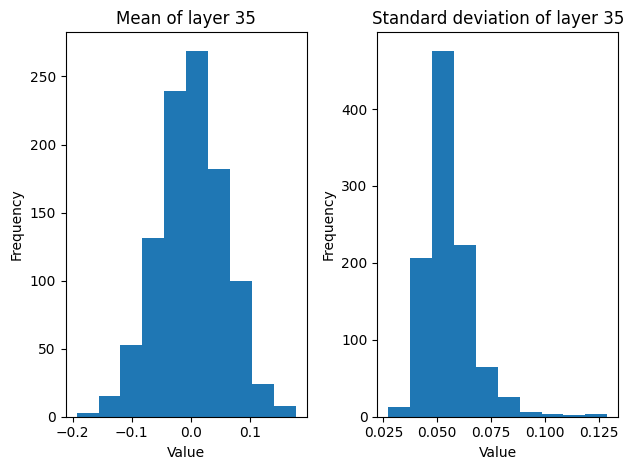

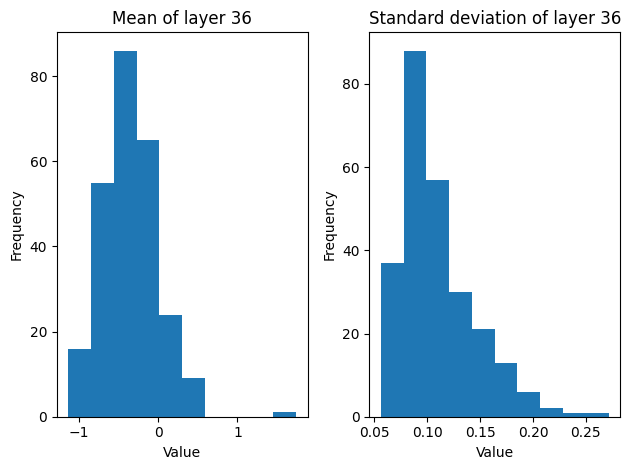

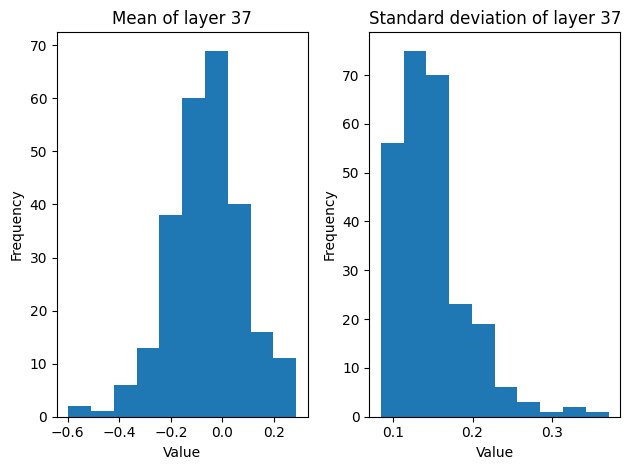

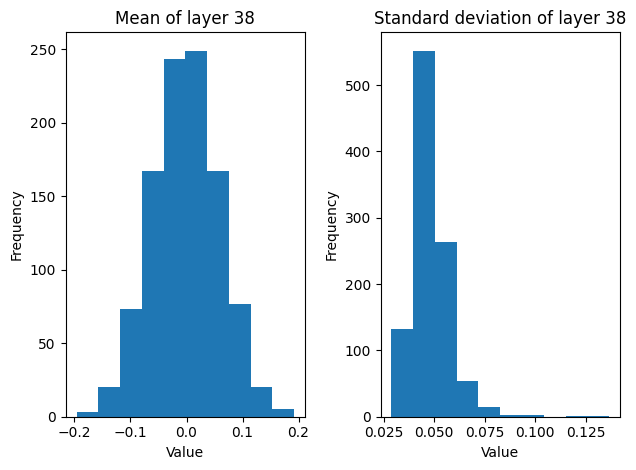

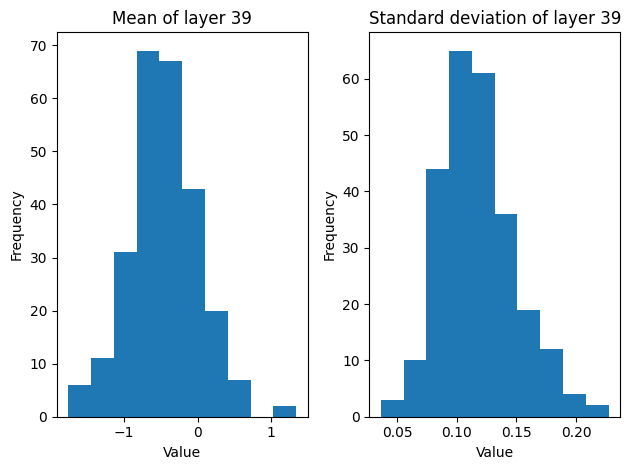

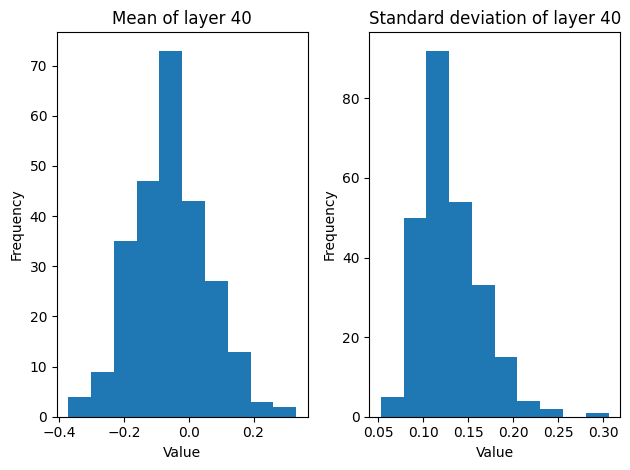

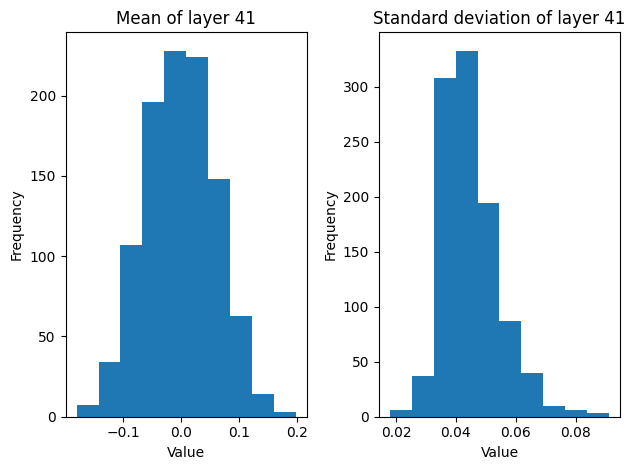

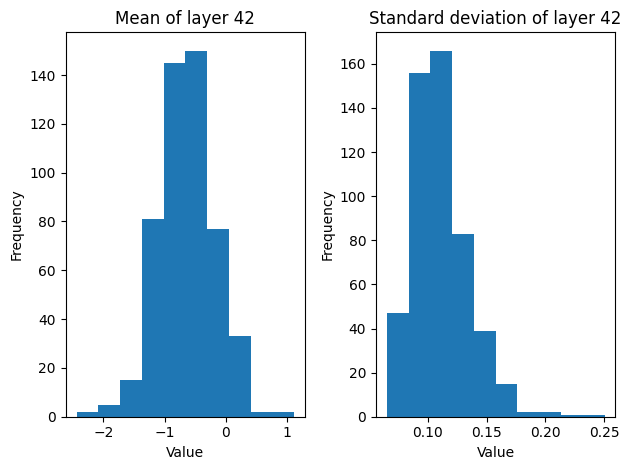

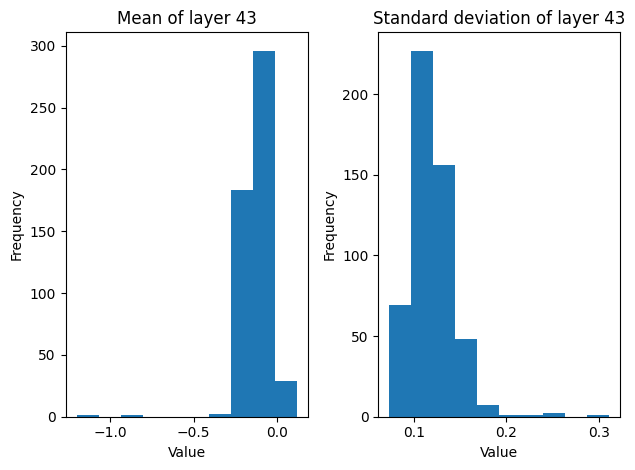

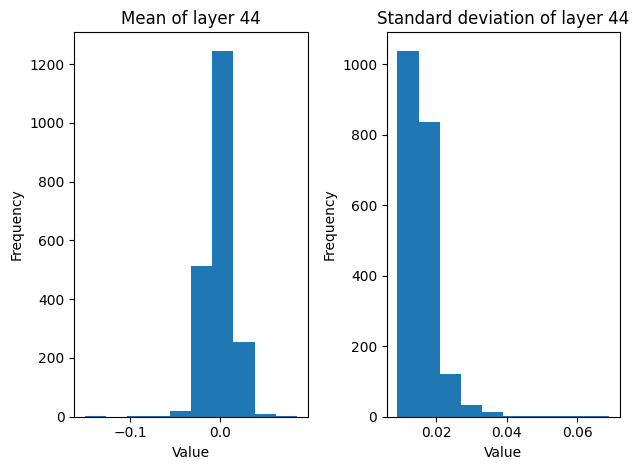

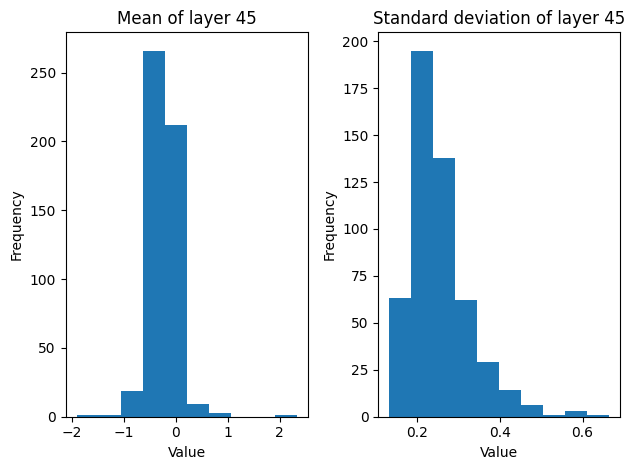

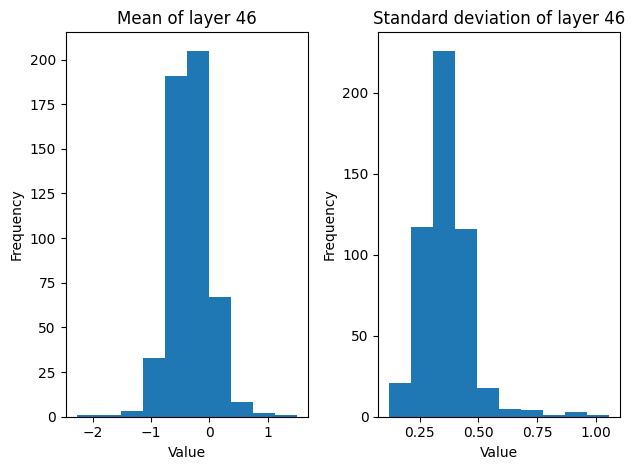

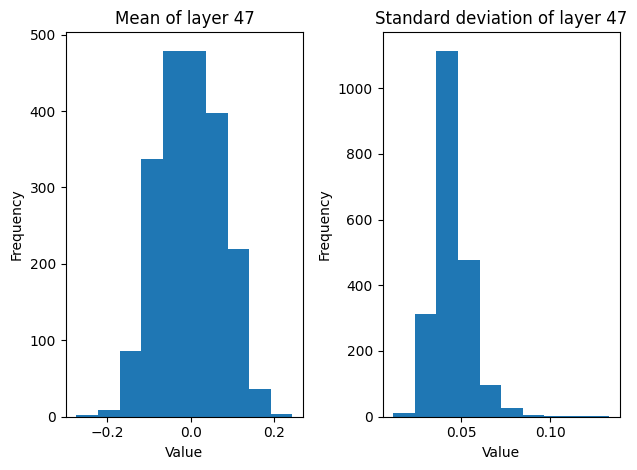

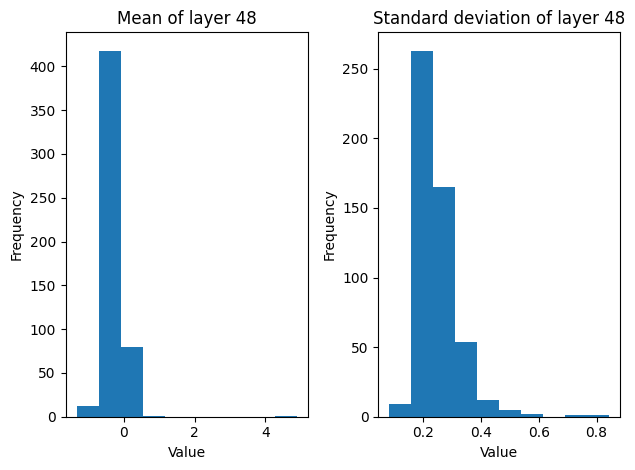

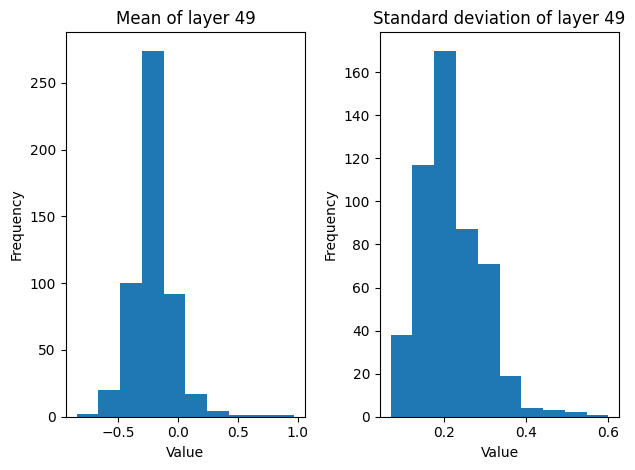

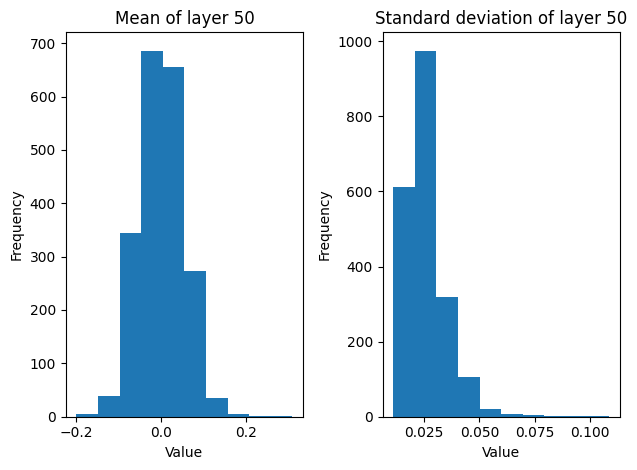

In [23]:
# analyze statistics
table, model1_statistics, model2_statistics = load_stats("/mnt/data/patrick.koller/masterthesis/data/results", device)

plot_layer_mean_std(model1_statistics, "Model 1")
plot_layer_mean_std(model2_statistics, "Model 2")